Привет, меня зовут Артем Носенко и я буду проверять твой проект.
<br>Небольшая вступительная часть и начнем работу)
<br> Если не против, то предлагаю общаться на «ты». Если это не удобно - дай знать, и мы перейдем на "вы". Моя основная цель — не указать на совершенные ошибки, а поделиться своим опытом и помочь сделать твой проект лучше. Для этого я буду использовать разный стиль оформления комментариев.
<div class="alert alert-block alert-success">
✔️ Все хорошо.
</div>

<div class="alert alert-warning">
⚠️ Критических замечаний нет, но есть возможность сделать твою работу лучше.
</div>

<div class="alert alert-block alert-danger">
❌ Если требуются исправления. Работа не может быть принята с красными комментариями.
</div>


Давай работать над проектом в диалоге: если ты что-то меняешь в проекте по моим рекомендациям — пиши об этом.
Будет очень хорошо, если ты будешь помечать свои действия следующим образом:
<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> ...
</div>
Пожалуйста, не перемещай, не изменяй и не удаляй мои комментарии. Всё это поможет выполнить повторную проверку твоего проекта оперативнее».


<div class="alert alert-block alert-info">
<b>Комментарий студента v1:</b>    

Привет, Артем! 🤝 
</div>

#### Проект. Рекомендательные системы в банковской сфере. Исследование данных и моделирование

##### Содержание

 - Импорт библиотек, настройка параметров, определения функций
 - Загрузка данных, общий обзор
 - Создание таргета, сплит на обучающий/тестовый датасеты
 - Выбор метрик
 - Анализ отдельных переменных, вывод закономерностей
 - Определение функции для препроцессинга данных
 - Обзор зависимостей между признаками и таргетом с помощью средств phik, оценка высококардинальных переменных
 - Проверка препроцессинга, формирование шага предобработки общего пайплайна
 - Итоги проведения исследовательского анализа
 - Обучение модели
 - Подготовка функций для встраивания модели в сервис предсказаний
 - Получение и интерпретация метрик  
 - Сравнение метрик модели с константными предсказаниями
 - Получение рекомендаций на основе вероятностей предсказаний
 - Детализированные оценки для всех таргетов
 - Итоги этапа моделирования 

<b>Комментарий от ревьюера v1</b>
<div class="alert alert-block alert-success">
✔️ Отлично, описаны все основные шаги твоего проекта!
</div>


##### Импорт библиотек, настройка параметров, определения функций

Данные представляют собой csv-файл, загружаемый по ссылке.  
Загрузка осуществляется в коде или вручную по инструкции в README.md.  

Следуя стандартам PEP8, аннотации функций и комментарии в коде написаны на английском.   
Действия по выполнению проекта находятся в ячейках markdown.

In [1]:
# Standard library imports
import os
import time
import json
import subprocess
from datetime import datetime
from pathlib import Path
import warnings
import sys

# Third-party utilities
import requests
from dotenv import load_dotenv  # Load environment variables from .env file
import psutil  # System resource management (CPU, memory)
from humanize import naturalsize  # Human-readable file sizes
import textwrap

# Type annotations
from typing import Optional, List, Dict, Tuple

# Data processing
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, 
    roc_curve, auc, precision_recall_curve, average_precision_score
)
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier

# Statistical analysis
import scipy.stats as stats
import phik  # For advanced correlation analysis

# Model saving/loading
import joblib

# ML Experiment tracking
import mlflow


# Load environment variables from .env file
load_dotenv()

# Random seed for reproducibility
RANDOM_STATE = 42

# Directories for data and models
DATA_DIR = "data"
MODEL_DIR = "models"

# Paths for data files and model artifacts
DATA_ZIP = Path(DATA_DIR, "data.zip")
DATA_CSV = Path(DATA_DIR, "data.csv")
DATA_PARQUET = Path(DATA_DIR, "data.parquet")
TRAIN_PARQUET = Path(DATA_DIR, "df_train.parquet")
TEST_PARQUET = Path(DATA_DIR, "df_test.parquet")
MODEL_PKL = Path(MODEL_DIR, "model.pkl")
FITTED_MODEL = Path(MODEL_DIR, "fitted_model.pkl")
MODEL_PARAMS = Path(MODEL_DIR, 'model_params.json')
SAMPLE_JSON = Path(MODEL_DIR, 'sample.json')

# Lucky user for test case
LUCKY_USER = 376088

# Date configurations
TRAIN_TEST_SPLIT_DATE = '2016-02-28'
START_TRAIN_DATE = '2015-07-28'

# Database and MLflow configurations from environment variables
POSTGRES_SQL_CONN = f"postgresql://{os.getenv('DB_DESTINATION_USER')}:" \
                    f"{os.getenv('DB_DESTINATION_PASSWORD')}@" \
                    f"{os.getenv('DB_DESTINATION_HOST')}:" \
                    f"{os.getenv('DB_DESTINATION_PORT')}/" \
                    f"{os.getenv('DB_DESTINATION_NAME')}"
MLFLOW_PORT = os.getenv('MLFLOW_PORT')
S3_BUCKET_NAME = os.getenv('S3_BUCKET_NAME')
TRACKING_SERVER_CONN = os.getenv('TRACKING_SERVER_CONN')

# MLflow server command
MLFLOW_COMMAND = [
    "mlflow", "server",
    "--backend-store-uri", POSTGRES_SQL_CONN,
    "--registry-store-uri", POSTGRES_SQL_CONN,
    "--default-artifact-root", f"s3://{S3_BUCKET_NAME}",
    "--no-serve-artifacts",
    "--host", "0.0.0.0",
    "--port", MLFLOW_PORT
]

# Load model parameters if they exist
if MODEL_PARAMS.exists():
    with open(MODEL_PARAMS, 'r') as f:
        json_data = json.load(f)
        target_names = json_data.get('target_names', [])
        target_names_eng = json_data.get('target_names_eng', [])
        income_mean = json_data.get('income_mean', 0.0)
else:
    target_names, target_names_eng = [], []
    income_mean = 0.0

# Plotting and display settings
plt.rcParams['figure.figsize'] = [20, 6]
np.set_printoptions(precision=4, suppress=True)
pd.options.display.float_format = '{:.4f}'.format

# Optionally, suppress runtime warnings (uncomment if needed)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
# Utility Functions for Data Analysis and Classification

# 1. display_nans_history(df, col) -> None
#    Displays NaN counts for a column, grouped by 'fetch_date', with a total summary.

# 2. display_statistics(data) -> pd.DataFrame
#    Provides basic stats for each column: data type, NaNs, zero counts, and top 5 unique values.

# 3. get_mem_usage(top_k=None) -> None
#    Shows system memory usage, optionally listing top-k largest variables in memory.

# 4. calculate_roc_auc(y_true, y_pred_proba) -> dict
#    Calculates 'micro', 'macro', and 'weighted' ROC AUC scores for multi-output classification.

# 5. calculate_metrics(y_true, y_pred, y_pred_proba, zero_division=0) -> pd.DataFrame
#    Computes Accuracy, Precision, Recall, F1, and ROC AUC for multi-output classification.

# 6. plot_roc_curve(y_true, y_pred_proba, label_name) -> None
#    Plots the ROC curve for binary classification with the AUC value.


# Function to display history of NaNs in a specific column
def display_nans_history(df: pd.DataFrame, col: str) -> None:
    """
    Display the count of missing values (NaNs) in a given column over time.
    
    Parameters:
    df (pd.DataFrame): The dataframe containing the data.
    col (str): The column to analyze for missing values.
    """
    print(f"Пропущенные значения в столбце {col} ({df.attrs[col]['rus']})")
    
    summary_df = df.groupby('fetch_date')[col].agg(['count', lambda x: x.isna().sum()])
    summary_df.columns = ['count', 'nan_sum']

    summary_df.reset_index(inplace=True)
    summary_df['fetch_date'] = summary_df['fetch_date'].dt.strftime('%Y-%m-%d')

    total_row = pd.DataFrame({
        'fetch_date': ['Total'],
        'count': [summary_df['count'].sum()],
        'nan_sum': [summary_df['nan_sum'].sum()]
    })
    summary_df = pd.concat([summary_df, total_row], ignore_index=True)

    summary_df.index = [''] * len(summary_df)
    display(summary_df.style.format({
        'count': '{:,.0f}',
        'nan_sum': '{:,.0f}'
    }))


# Function to display basic statistics of the data
def display_statistics(data: pd.DataFrame) -> pd.DataFrame:
    """
    Display basic statistics for each column in the dataframe.
    
    Parameters:
    data (pd.DataFrame): The dataframe to analyze.
    
    Returns:
    pd.DataFrame: A dataframe containing statistics for each column.
    """
    indicators: List[Dict] = []
    
    for col in data.columns:
        indicators.append({
            'type': data[col].dtypes,
            'types': set(map(lambda v: type(v).__name__, data[col].unique())),
            'count': data[col].count(),
            'NaNs': data[col].isna().sum(),
            'zero_values': data[col].eq(0).sum(),
            'nunique': data[col].nunique(),
            'unique-top5': data[col].value_counts().head().to_dict()
        })
    
    return pd.DataFrame(indicators, index=[x for x in data.columns])


def get_mem_usage(top_k: Optional[int] = None) -> None:
    """
    Display memory usage statistics, including the top-k largest variables 
    in the current environment and system memory stats.

    Args:
        top_k (Optional[int]): The number of top variables to display, sorted by size.
                               If None, the system memory stats are displayed only.
    """
    if top_k:
        print(f"Топ-{top_k} объемных переменных:")
        # Get the size of each global variable and display the top_k largest
        for name, size in sorted(((name, sys.getsizeof(value)) for name, value in globals().items()), key=lambda x: -x[1])[:top_k]:
            print(f"{name}: {naturalsize(size)}")
        print()

    memory = psutil.virtual_memory()
    print(f"Общая память: {naturalsize(memory.total)}")
    print(f"Доступная память: {naturalsize(memory.available)}")


def calculate_roc_auc(y_true: np.ndarray, y_pred_proba: np.ndarray) -> dict:
    """
    Calculate ROC AUC scores (micro, macro, and average) for multi-output classification.

    Parameters:
    y_true (np.ndarray): True labels.
    y_pred_proba (np.ndarray): Predicted probabilities.

    Returns:
    dict: ROC AUC scores.
    """
    if isinstance(y_pred_proba, list):
        y_pred_proba = np.array(y_pred_proba)

    if len(y_pred_proba.shape) == 3:
        y_pred_proba_class_1 = y_pred_proba[:, :, 1].T
    else:
        y_pred_proba_class_1 = y_pred_proba

    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values

    # Filter columns with more than one unique value
    valid_columns = [col for col in range(y_true.shape[1]) if len(np.unique(y_true[:, col])) > 1]

    return {
        'micro': roc_auc_score(y_true[:, valid_columns], y_pred_proba_class_1[:, valid_columns], average='micro'),
        'macro': roc_auc_score(y_true[:, valid_columns], y_pred_proba_class_1[:, valid_columns], average='macro'),
        'average': roc_auc_score(y_true[:, valid_columns], y_pred_proba_class_1[:, valid_columns], average='weighted')
    }


def calculate_metrics(y_true: np.ndarray, y_pred: np.ndarray, y_pred_proba: np.ndarray, zero_division: int = 0) -> pd.DataFrame:
    """
    Calculate various classification metrics such as Accuracy, Precision, Recall, F1, and ROC AUC.

    Parameters:
    y_true (np.ndarray): True labels.
    y_pred (np.ndarray): Predicted labels.
    y_pred_proba (np.ndarray): Predicted probabilities.
    zero_division (int): Determines the behavior when division by zero occurs (default is 0).

    Returns:
    pd.DataFrame: DataFrame with calculated metrics for micro, macro, and average scores.
    """
    common_kwargs = {
    'y_true': y_true,
    'y_pred': y_pred,
    'zero_division': zero_division
    }

    metrics = {
        'Accuracy': {
            'micro': -1,
            'macro': -1,
            'average': accuracy_score(y_true, y_pred)
        },
        'Precision': {
            'micro': precision_score(average='micro', **common_kwargs),
            'macro': precision_score(average='macro', **common_kwargs),
            'average': precision_score(average='weighted', **common_kwargs)
        },
        'Recall': {
            'micro': recall_score(average='micro', **common_kwargs),
            'macro': recall_score(average='macro', **common_kwargs),
            'average': recall_score(average='weighted', **common_kwargs)
        },
        'F1': {
            'micro': f1_score(average='micro', **common_kwargs),
            'macro': f1_score(average='macro', **common_kwargs),
            'average': f1_score(average='weighted', **common_kwargs)
        },
        'ROC AUC': calculate_roc_auc(y_true, y_pred_proba)
    }

    return pd.DataFrame(metrics).T


def plot_roc_curve(y_true: np.ndarray, y_pred_proba: np.ndarray, label_name: str) -> None:
    """
    Plot the ROC curve for binary classification.

    Parameters:
    y_true (np.ndarray): True labels.
    y_pred_proba (np.ndarray): Predicted probabilities.
    label_name (str): Label for the ROC curve.
    """
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values
    
    fpr, tpr, _ = roc_curve(y_true.ravel(), y_pred_proba.ravel())
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f'{label_name} (AUC = {roc_auc:.4f})')

<b>Комментарий от ревьюера v1</b>
<div class="alert alert-block alert-success">
✔️ Импорты сделаны, основные функции реализованы!
</div>

<div class="alert alert-warning">
⚠️ На подуматть: возможно функции стоило вынести в отдельную ячейку. По крайней мере я бы сам так делал.
</div>

<div class="alert alert-block alert-info">
<b>Комментарий студента v1:</b>    

Это классика, целеполагание каждой ячейки, структура и т.п., спасибо за напоминание, поправил. 
</div>

На основе задания создадим словарь с информацией обо всех признаках.

In [3]:
attrs = {
    'fetch_date': {
        'rus': 'Колонка для разделения таблицы', 'eng': '', 'esp': 'fecha_dato', 'values': {}
    },
    'id': {
        'rus': 'Идентификатор пользователя', 'eng': '', 'esp': 'ncodpers', 'values': {}
    },
    'ind_employee': {
        'rus': 'Статус занятости', 'eng': '', 'esp': 'ind_empleado',
        'values': {
            'A': 'трудоустроен', 'B': 'безработный, раньше работал', 'F': 'иждивенец',
            'N': 'безработный', 'P': 'пассивный (статус не определён)'
        }
    },
    'country_of_residence': {
        'rus': 'Страна резидентства', 'eng': '', 'esp': 'pais_residencia', 'values': {}
    },
    'gender': {
        'rus': 'Пол', 'eng': '', 'esp': 'sexo', 'values': {}
    },
    'age': {
        'rus': 'Возраст', 'eng': '', 'esp': 'age', 'values': {}
    },
    'registration_date': {
        'rus': 'Дата, когда клиент впервые заключил договор в банке', 'eng': '', 
        'esp': 'fecha_alta', 'values': {}
    },
    'ind_new_client': {
        'rus': 'Признак нового клиента', 'eng': '', 'esp': 'ind_nuevo', 
        'values': {'1': 'если клиент зарегистрировался за последние 6 месяцев'}
    },
    'tenure_months': {
        'rus': 'Стаж клиента (в месяцах)', 'eng': '', 'esp': 'antiguedad', 'values': {}
    },
    'client_relationship_status': {
        'rus': 'Признак первичного клиента', 'eng': '', 'esp': 'indrel',
        'values': {
            '1': 'первичный клиент', '99': 'первичный клиент в течении месяца, но не в конце'
        }
    },
    'last_date_as_primary': {
        'rus': 'Последняя дата, когда клиент был премиальным', 'eng': '', 
        'esp': 'ult_fec_cli_1t', 'values': {}
    },
    'client_type_1m': {
        'rus': 'Тип клиента в начале месяца', 'eng': '', 'esp': 'indrel_1mes',
        'values': {
            '1': 'премиальный', '2': 'собственник', 'P': 'потенциальный', 
            '3': 'раньше был премиальным', '4': 'раньше был собственником'
        }
    },
    'client_activity_1m': {
        'rus': 'Тип клиента в начале месяца', 'eng': '', 'esp': 'tiprel_1mes',
        'values': {
            'A': 'активный', 'I': 'неактивный', 'P': 'бывший', 'R': 'потенциальный'
        }
    },
    'ind_resident': {
        'rus': 'Если страна проживания совпадает со страной банка', 'eng': '', 
        'esp': 'indresi', 'values': {}
    },
    'ind_foreigner': {
        'rus': 'Если страна рождения клиента отличается от страны банка', 'eng': '', 
        'esp': 'indext', 'values': {}
    },
    'ind_spouse_employee': {
        'rus': 'Признак супруга работника', 'eng': '', 'esp': 'conyuemp', 
        'values': {'1': 'если клиент супруг(а) работника'}
    },
    'entry_channel': {
        'rus': 'Канал, по которому пришел пользователь', 'eng': '', 'esp': 'canal_entrada', 
        'values': {}
    },
    'ind_deceased': {
        'rus': 'Индекс актуальности счёта (англ. Deceased index, N/S)', 'eng': '', 
        'esp': 'indfall', 'values': {}
    },
    'address_type': {
        'rus': 'Тип адреса', 'eng': '', 'esp': 'tipodom', 'values': {'1': 'основной адрес'}
    },
    'province_code': {
        'rus': 'Код провинции (адреса клиента)', 'eng': '', 'esp': 'cod_prov', 'values': {}
    },
    'province_name': {
        'rus': 'Имя провинции', 'eng': '', 'esp': 'nomprov', 'values': {}
    },
    'ind_client_activity': {
        'rus': 'Активность пользователя', 'eng': '', 'esp': 'ind_actividad_cliente',
        'values': {'1': 'активный', '0': 'неактивный'}
    },
    'income': {
        'rus': 'Доход домохозяйства', 'eng': '', 'esp': 'renta', 'values': {}
    },
    'client_segment': {
        'rus': 'Сегментация', 'eng': '', 'esp': 'segmento', 
        'values': {'1': 'VIP', '2': 'Обыкновенные', '3': 'Выпускники колледжей'}
    },
    'ind_1m_savings_acc': {
        'rus': 'Сберегательный счёт', 'eng': 'Savings Account', 'esp': 'ind_ahor_fin_ult1', 
        'values': {}
    },
    'ind_1m_guarantee': {
        'rus': 'Банковская гарантия', 'eng': 'Bank Guarantee', 'esp': 'ind_aval_fin_ult1', 
        'values': {}
    },
    'ind_1m_checking_acc': {
        'rus': 'Текущие счета', 'eng': 'Checking Account', 'esp': 'ind_cco_fin_ult1', 
        'values': {}
    },
    'ind_1m_derivatives': {
        'rus': 'Деривативный счёт', 'eng': 'Derivatives Account', 'esp': 'ind_cder_fin_ult1', 
        'values': {}
    },
    'ind_1m_payroll_acc': {
        'rus': 'Зарплатный проект', 'eng': 'Payroll Account', 'esp': 'ind_cno_fin_ult1', 
        'values': {}
    },
    'ind_1m_junior_acc': {
        'rus': 'Детский счёт', 'eng': 'Junior Account', 'esp': 'ind_ctju_fin_ult1', 
        'values': {}
    },
    'ind_1m_mature_acc_3': {
        'rus': 'Особый счёт 3', 'eng': 'Special Account 3', 'esp': 'ind_ctma_fin_ult1', 
        'values': {}
    },
    'ind_1m_operations_acc': {
        'rus': 'Особый счёт', 'eng': 'Operations Account', 'esp': 'ind_ctop_fin_ult1', 
        'values': {}
    },
    'ind_1m_pension_acc_2': {
        'rus': 'Особый счёт 2', 'eng': 'Special Account 2', 'esp': 'ind_ctpp_fin_ult1', 
        'values': {}
    },
    'ind_1m_short_term_deposit': {
        'rus': 'Краткосрочный депозит', 'eng': 'Short-Term Deposit', 'esp': 'ind_deco_fin_ult1', 
        'values': {}
    },
    'ind_1m_medium_term_deposit': {
        'rus': 'Среднесрочный депозит', 'eng': 'Medium-Term Deposit', 'esp': 'ind_deme_fin_ult1', 
        'values': {}
    },
    'ind_1m_long_term_deposit': {
        'rus': 'Долгосрочный депозит', 'eng': 'Long-Term Deposit', 'esp': 'ind_dela_fin_ult1', 
        'values': {}
    },
    'ind_1m_digital_account': {
        'rus': 'Цифровой счёт', 'eng': 'Digital Account', 'esp': 'ind_ecue_fin_ult1', 
        'values': {}
    },
    'ind_1m_cash_funds': {
        'rus': 'Денежный средства', 'eng': 'Cash Funds', 'esp': 'ind_fond_fin_ult1', 
        'values': {}
    },
    'ind_1m_mortgage': {
        'rus': 'Ипотека', 'eng': 'Mortgage', 'esp': 'ind_hip_fin_ult1', 'values': {}
    },
    'ind_1m_pension_plan': {
        'rus': 'Пенсионный план', 'eng': 'Pension Plan', 'esp': 'ind_plan_fin_ult1', 'values': {}
    },
    'ind_1m_loans': {
        'rus': 'Кредит', 'eng': 'Loans', 'esp': 'ind_pres_fin_ult1', 'values': {}
    },
    'ind_1m_tax_account': {
        'rus': 'Налоговый счёт', 'eng': 'Tax Account', 'esp': 'ind_reca_fin_ult1', 'values': {}
    },
    'ind_1m_credit_card': {
        'rus': 'Кредитная карта', 'eng': 'Credit Card', 'esp': 'ind_tjcr_fin_ult1', 'values': {}
    },
    'ind_1m_securities': {
        'rus': 'Ценные бумаги', 'eng': 'Securities', 'esp': 'ind_valo_fin_ult1', 'values': {}
    },
    'ind_1m_home_acc': {
        'rus': 'Домашний счёт', 'eng': 'Home Account', 'esp': 'ind_viv_fin_ult1', 'values': {}
    },
    'ind_1m_salary_acc': {
        'rus': 'Аккаунт для выплаты зарплаты', 'eng': 'Salary Account', 'esp': 'ind_nomina_ult1', 
        'values': {}
    },
    'ind_1m_pension_obligation_account': {
        'rus': 'Аккаунт для пенсионных обязательств', 'eng': 'Pension Obligation Account', 
        'esp': 'ind_nom_pens_ult1', 'values': {}
    },
    'ind_1m_debit_account': {
        'rus': 'Дебетовый аккаунт', 'eng': 'Debit Account', 'esp': 'ind_recibo_ult1', 
        'values': {}
    }
}

<b>Комментарий от ревьюера v1</b>
<div class="alert alert-block alert-success">
✔️ Очень полезный словарик! Круто, спасибо!
</div>

In [4]:
new_columns = {v['esp']: k for k, v in attrs.items()}

date_columns = ['fetch_date', 'registration_date', 'last_date_as_primary']

dtype_spec: Dict[str, str] = {
    'age': 'str',
    'tenure_months': 'str',
    'client_type_1m': 'str',
    'ind_spouse_employee': 'str',
}

In [5]:
os.makedirs(DATA_DIR, exist_ok=True)

if not DATA_ZIP.exists():
    print(f"Файл {DATA_ZIP} не существует. Загрузка...", end='')
    download_command = f'wget -q -O {DATA_ZIP} $(yadisk-direct https://disk.yandex.com/d/Io0siOESo2RAaA)'
    subprocess.run(download_command, shell=True, check=True)
    print(" OK.")
else:
    print(f"Файл {DATA_ZIP} существует, загрузка не требуется.")

if not DATA_CSV.exists():
    print(f"Файл {DATA_CSV} не существует. Распаковка архива...", end='')
    unzip_command = f'unzip -p {DATA_ZIP} train_ver2.csv > {DATA_CSV}'
    subprocess.run(unzip_command, shell=True, check=True)
    print(" OK.")
else:
    print(f"Файл {DATA_CSV} существует, распаковка не требуется.")

if DATA_PARQUET.exists():
    print(f"Файл {DATA_PARQUET} существует, открытие...", end='')
    df = pd.read_parquet(DATA_PARQUET)
else:
    print(f"Файл {DATA_PARQUET} не существует, парсинг (< 4 минут) и сохранение...", end='')
    df = pd.read_csv(
        DATA_CSV, 
        dtype=dtype_spec,
        parse_dates=date_columns,
        date_format='%Y-%m-%d',
        low_memory=False,
        header=0,
        names=list(new_columns.values())
    )
    df.attrs = attrs
    df.to_parquet(DATA_PARQUET)

print(f" OK.")

directory = Path(DATA_DIR)
print(f"Содержимое каталога '{directory}':")

for file in directory.iterdir():
    if file.is_file():
        print(f" - {file.name}: {naturalsize(file.stat().st_size)}")

display(df.head())

get_mem_usage()

Файл data/data.zip существует, загрузка не требуется.
Файл data/data.csv существует, распаковка не требуется.
Файл data/data.parquet существует, открытие... OK.
Содержимое каталога 'data':
 - data.csv: 2.3 GB
 - data.zip: 224.7 MB
 - data.parquet: 206.4 MB
 - df_train.parquet: 70.7 MB
 - df_test.parquet: 17.9 MB


,fetch_date,id,ind_employee,country_of_residence,gender,age,registration_date,ind_new_client,tenure_months,client_relationship_status,...,ind_1m_mortgage,ind_1m_pension_plan,ind_1m_loans,ind_1m_tax_account,ind_1m_credit_card,ind_1m_securities,ind_1m_home_acc,ind_1m_salary_acc,ind_1m_pension_obligation_account,ind_1m_debit_account
0,2015-01-28,1375586,N,ES,H,35,2015-01-12,0.0000,6,1.0000,...,0,0,0,0,0,0,0,0.0000,0.0000,0
1,2015-01-28,1050611,N,ES,V,23,2012-08-10,0.0000,35,1.0000,...,0,0,0,0,0,0,0,0.0000,0.0000,0
2,2015-01-28,1050612,N,ES,V,23,2012-08-10,0.0000,35,1.0000,...,0,0,0,0,0,0,0,0.0000,0.0000,0
3,2015-01-28,1050613,N,ES,H,22,2012-08-10,0.0000,35,1.0000,...,0,0,0,0,0,0,0,0.0000,0.0000,0
4,2015-01-28,1050614,N,ES,V,23,2012-08-10,0.0000,35,1.0000,...,0,0,0,0,0,0,0,0.0000,0.0000,0


Общая память: 33.7 GB
Доступная память: 20.2 GB


<b>Комментарий от ревьюера v1</b>
<div class="alert alert-block alert-success">
✔️ ОК! По-видимому разработку ты производил на ВМ.
</div>

##### Загрузка данных, общий обзор

Данные представляют собой обезличенную информацию испанского банка о своих клиентах в разрезе приобретения ими продуктов банка.  
Файл загружается, проводится начальный парсинг дат и автоматическое переименование названий колонок с испанского на английский язык из словаря new_columns, генерируемого из словаря attrs, составленного по описанию задания.  
Поскольку данные в памяти занимают окло 7 Гб, проводится мониторинг свободной памяти с помощью функции get_mem_usage().

Посмотрим на структуру данных.

In [6]:
# ~ 40 s

display_statistics(df)

,type,types,count,NaNs,zero_values,nunique,unique-top5
fetch_date,datetime64[ns],{Timestamp},13647309,0,0,17,"{2016-05-28 00:00:00: 931453, 2016-04-28 00:00..."
id,int64,{int64},13647309,0,0,956645,"{538031: 17, 538018: 17, 538021: 17, 538023: 1..."
ind_employee,object,"{str, NoneType}",13619575,27734,0,5,"{'N': 13610977, 'B': 3566, 'F': 2523, 'A': 249..."
country_of_residence,object,"{str, NoneType}",13619575,27734,0,118,"{'ES': 13553710, 'FR': 5161, 'AR': 4835, 'DE':..."
gender,object,"{str, NoneType}",13619505,27804,0,2,"{'V': 7424252, 'H': 6195253}"
age,object,{str},13647309,0,0,121,"{' 23': 779884, ' 22': 736314, ' 24': 734785, ..."
registration_date,datetime64[ns],"{NaTType, Timestamp}",13619575,27734,0,6756,"{2014-07-28 00:00:00: 57389, 2014-10-03 00:00:..."
ind_new_client,float64,{float64},13619575,27734,12808368,2,"{0.0: 12808368, 1.0: 811207}"
tenure_months,object,{str},13647309,0,0,259,"{' 12': 243160, ' 21': 214795, ' 1..."
client_relationship_status,float64,{float64},13619575,27734,0,2,"{1.0: 13594782, 99.0: 24793}"


Данных много, но они однотипные.   
Можно выделить:  
 - 3 числовые переменные (в том числе и по смыслу) age, tenure_months, income  
 - 17 категориальных переменных с разной кардинальностью
 - 24 бинарных переменных с шаблоном названий ind_1m_*, которые и являются целью предсказаний
 - 3 даты и 1 колонка id  
   
Много пропусков встречается в переменных last_date_as_primary, ind_spouse_employee, income.  
Для большинства переменных характерен заметный дисбаланс, встречаются нерелевантные признаки (address_type).  
Данные очень разрежены, особенно у индикаторных признаков ind_1m_*.    
  
Данные поддаются анализу, но сначала нужно определиться с таргетом.

<b>Комментарий от ревьюера v1</b>
<div class="alert alert-block alert-success">
✔️ Все корректно!
</div>

##### Создание таргета, сплит на обучающий/тестовый датасеты

Цель сервиса - предсказать продукты, которые клиент приобретет в следующем периоде. Другими словами, тренировочные данными будут сведения о купленных продуктах до текущего месяца, а таргетом - сведения о вновь приобретенных продуктах в следующем месяце.  

In [7]:
def count_changes(grouped: pd.Series, type: int = 0) -> int:
    """
    Count the number of changes in a grouped pandas Series.

    Parameters:
    grouped (pd.Series): The Series containing grouped data.
    type (int, optional): The type of change to count. 
                          If 0, counts all non-zero changes. 
                          If other, counts changes to that specific value. Default is 0.

    Returns:
    int: The total count of changes in the grouped Series.
    """
    # Calculate the difference between consecutive rows in the grouped data
    diffs = grouped.diff()

    # If type is 0, count all non-zero changes; otherwise, count changes to the specific value (type)
    if type == 0:
        changes = diffs.ne(0) & diffs.notna()
    else:
        changes = diffs.eq(type) & diffs.notna()

    # Group by 'id' column and sum the changes for each group, then sum the total changes
    changes_count = changes.groupby(df['id']).sum()
    
    return changes_count.sum().sum()

Мы определили функцию, которая считает различия в сгруппированных данных.  
Выведем возможные изменения и статистики покупок продуктов в данных, сгруппированных по клиентам ('id').

In [8]:
# ~ 1 min
product_features = [col for col in df.columns if col.startswith('ind_1m_')]

grouped = df.groupby('id')[product_features]

num_of_periods = df['fetch_date'].nunique()
num_of_clients = df['id'].nunique()
num_of_interactions = grouped.sum().sum(axis=1).mean()

print(f"Среднее количество периодов пользования продуктами: {num_of_interactions:.2f} в течение {num_of_periods} периодов")
print(f"Среднее количество продуктов на одного клиента: {grouped.mean().sum(axis=1).mean():.2f}")
print(f"Доля клиентов, пользующихся в среднем не более, чем одним продуктом: {(grouped.mean().sum(axis=1) <=1).mean():.2%}")

sum_of_interactions = grouped.sum().sum(axis=1)
print(f"Доля клиентов, не пользующихся никакими продуктами: {(sum_of_interactions ==0).mean():.2%}")
print()

print(f"Доля клиентов, у которых в начале и в конце истории одинаковый набор продуктов: "
        f"{(grouped.first() == grouped.last()).all(axis=1).sum() / num_of_clients:.2%},")
print(f"Доля клиентов, у которых ни разу не менялся набор продуктов: "
        f"{(grouped.first() == grouped.mean()).all(axis=1).sum() / num_of_clients:.2%}")
print()

interactions_total = df[product_features].count().sum() - grouped.first().count().sum() # без первых строк, которые изменениями не являются

previous_values = grouped.shift(1)
continue_0 = ((previous_values == 0) & (df[product_features] == 0)).sum().sum()
continue_1 = ((previous_values == 1) & (df[product_features] == 1)).sum().sum()
changes = count_changes(grouped)
change_0_1 = count_changes(grouped, 1)
change_1_0 = count_changes(grouped, -1)

print(f"Всего взаимодействий: {interactions_total:,.0f} (100%),\n"
      f" - с изменением состояния: {changes:,.0f} ({changes / interactions_total:.2%}):\n"
      f" - - из них покупок (0->1): {change_0_1:,.0f} ({change_0_1 / interactions_total:.2%}),\n"
      f" - - отказов от услуг (1->0): {change_1_0:,.0f} ({change_1_0 / interactions_total:.2%}),\n"
      f" - без изменения состояния: {continue_0+continue_1:,.0f} ({(continue_0+continue_1) / interactions_total:.2%}):\n"
      f" - - продолжили пользоваться (1->1): {continue_1:,.0f} ({continue_1 / interactions_total:.2%}),\n"
      f" - - продолжили не пользоваться (0->0): {continue_0:,.0f} ({continue_0 / interactions_total:.2%})")

del previous_values

Среднее количество периодов пользования продуктами: 20.86 в течение 17 периодов
Среднее количество продуктов на одного клиента: 1.30
Доля клиентов, пользующихся в среднем не более, чем одним продуктом: 70.54%
Доля клиентов, не пользующихся никакими продуктами: 23.57%

Доля клиентов, у которых в начале и в конце истории одинаковый набор продуктов: 79.94%,
Доля клиентов, у которых ни разу не менялся набор продуктов: 74.56%

Всего взаимодействий: 304,550,014 (100%),
 - с изменением состояния: 1,097,241 (0.36%):
 - - из них покупок (0->1): 563,308 (0.18%),
 - - отказов от услуг (1->0): 533,933 (0.18%),
 - без изменения состояния: 303,452,381 (99.64%):
 - - продолжили пользоваться (1->1): 18,174,160 (5.97%),
 - - продолжили не пользоваться (0->0): 285,278,221 (93.67%)


Данные, как было отмечено, разреженные.  
Каждый пользователь в среднем пользуется одним продуктом за 17 месяцев, таких клиентов ~ 70%.   
Примечательно, что четверть клиентов не пользуются никакими продуктами.  
А за весь период данных 3/4 клиентов ничего не покупали и ни от чего не отказывались.  

Отсюда следует, какие у нас данные, как их фильтровать и как формировать таргет.  
Будем считать взаимодействием пользователя и продукта число 1 или 0, соответствующее факту покупки (пользования) или непользования клиентом данного продукта.  
Тогда два последовательных взаимодействия 0->1 будут означать новую покупку, 1->0 - отказ от продукта, взаимодействия 0->0 и 1->1 не изменяют состояние клиента.  
И из 300 млн взаимодействий всего лишь 0.18% (0->1) относятся к нашему таргету.  
Таргетом для текущего периода будет набор всех продуктов, которыми будет пользоваться клиент в следующем периоде. 
  
Итак, получим таргет сдвигом данных о продуктах на -1, т.е. на предыдущий период.  Обозначим новые столбцы как 'target__*',   
а также удалим ненужные последние строки в каждой группе (для них нет таргета).  
И оставим только тех клиентов, у которых была хотя бы 1 покупка за весь период.  
Остальные данные не сильно помогут в плане предсказания, поскольку отражают довольно устойчивую картину "неприобретения" клиентами продуктов банка.

<b>Комментарий от ревьюера v1</b>
<div class="alert alert-block alert-success">
✔️ Выводы достаточно подробно описаны, ты - молодец!
</div>


<div class="alert alert-warning">
⚠️ Не совсем корректное формирование таргета. Ты очищаешь свою выборку от клиентов без покупок (и по всей видимости от клиентов, которые не меняют продукт), таким образом допускаешь утечку таргета. 
    
При твоем подходе возможен такой вариант применения рекомендательной системы:
1) твои модели применяются (т.е выдают рекомендации) для клиентов с уже совершенными покупками.
    
2) для новых клиентов или клиентов без покупок необходимо разрабатывать отдельный подход.
</div>

<div class="alert alert-block alert-info">
<b>Комментарий студента v1: </b>   

Это тоже классика, конечно.  

Я думал, что, формируя таргет, я использую только будущие значения, т.е. эффект target leakage напрямую не проявляется.  
Но получается, что мы, конечно, манипулируем данными на основе значений таргета.  
Так или иначе, target filtration занимает вторую позицию в расстрельном списке непростительных ошибок в ML после target leakage )).

Фильтрация данных -> искажение распределений -> смещение модели -> переобучение на позитивном таргете, в общем, весь набор.

Объясню свою мотивацию. На первом этапе при разработке деплоя любые значительные манипуляции с данными, которые занимают в памяти 7 Гб (например, копирование или выделение массивных срезов), приводили к немедленной смерти ядра. Например, df в коде ниже перед последней фильтрацией занимает 16.3 Гб. Любые оптимизации предполагают облегченную выборку из данных, т.е. сначала мы берем какой-то срез, на котором модель быстро обучается, а потом можно проводить сотни экспериментов.   
Такой срез можно выбирать по-разному. Я решил все-таки сначала убрать клиентов без покупок, т.к. если исходить из того, что наши таргеты независимы, то, жертвуя репрезентативностью на одном таргете из 24, модель видит остальные 23 достаточно репрезентативно, даже без покупок. (Статистика показывает, что клиент за 17 месяцев пользуется в среднем 1.3 продуктом). В общем, я пренебрег некоторой частью 'нулевых' клиентов ради предсказаний всех остальных. Поэтому я так сильно обрезал датасет, достаточно быстро выстроил пайплайн и получил разумные метрики. Эту проблему с репрезентативностью неактивных покупателей я отметил, но не реализовал. Думал выбрать один из нескольких вариантов:  
 - ничего не урезать, 'утяжелить' минорный класс уже в модели настройкой class weights
 - сделать случайный downsample (~20%) 'шумного' преобладающего класса
 - для всех пользователей оставить только ограниченный набор неактивных периодов (например, не более n последних наблюдений методом .tail(n))   
  
В общем, оставил как есть. Все-таки в проекте основное внимание уделяется поднятию сервисов в контейнерах.  

Сейчас я попытался это исправить, отключив какую-либо фильтрацию и взяв вместо 17 месяцев последние 5, где 4 отвожу на train, 1 - на test.  

  
Если уменьшать количество неактивных пользователей, выигрыш получится небольшой, т.к. я все равно подаю на вход модели усеченные по времени данные.  
Если все же я бы отбрасывал неактивных пользователей, то *теперь* я бы делал это как downsampling, не пользуясь значениями таргета:
</div>

```
EXCESSIVE_USERS_FRACTION = 0.8

inactive_users = df.groupby('id')[product_features].sum().eq(0).all(axis=1)
inactive_to_remove = inactive_users[inactive_users].sample(frac=EXCESSIVE_USERS_FRACTION, random_state=RANDOM_STATE).index
df = df[~df.id.isin(inactive_to_remove)]
```
<div class="alert alert-block alert-info">
  
Вот основные изменения по сравнению с предыдущей версией:  
 - данные не фильтруются
 - для train/test берутся уменьшенные срезы
 - дисбаланс регулируется гиперпараметром CatBoostClassifier 'auto_class_weights'
 - исполнение предыдущих пунктов все-таки не дает разумного времени для обучения; поэтому мы еще дропаем непопулярные таргеты, для поверхностной оценки этого должно хватить  

Весь ноутбук пересчитан.

</div>

In [9]:
# Shift product feature columns by one period for each group (user), creating lagged values for the next time step
shifted_values = grouped.shift(-1)

# Create target columns where a transition from 0 to 1 (indicating a new product usage) occurs
df_targets = ((df[product_features] == 0) & (shifted_values == 1)).astype(int).add_prefix('target__')

# Assign the newly created target columns back to the original dataframe
for col in df_targets.columns:
    df[col] = df_targets[col]

# Delete the shifted values and temporary target dataframe to free up memory
del shifted_values, df_targets

# Identify all target columns that start with 'target__' (the columns created in the previous step)
targets = [col for col in df.columns if col.startswith("target__")]

# Remove the last row of each group (user) because it lacks future data for target creation
last_row_mask = df.groupby('id')['id'].transform('shift', -1).notna()
df = df[last_row_mask]

# Group by user ID and filter out users who have no positive targets (i.e., they did not have a 0 to 1 transition)
#grouped_0 = (df.groupby('id')[targets].sum().sum(axis=1) == 0)
#df = df[~df.id.isin(grouped_0[grouped_0].index)]

# Store the list of target columns in the dataframe's attributes for future reference
df.attrs['target__'] = targets

get_mem_usage()

Общая память: 33.7 GB
Доступная память: 15.1 GB


In [10]:
df.fetch_date.unique()

<DatetimeArray>
['2015-01-28 00:00:00', '2015-02-28 00:00:00', '2015-03-28 00:00:00',
 '2015-04-28 00:00:00', '2015-05-28 00:00:00', '2015-06-28 00:00:00',
 '2015-07-28 00:00:00', '2015-08-28 00:00:00', '2015-09-28 00:00:00',
 '2015-10-28 00:00:00', '2015-11-28 00:00:00', '2015-12-28 00:00:00',
 '2016-01-28 00:00:00', '2016-02-28 00:00:00', '2016-03-28 00:00:00',
 '2016-04-28 00:00:00']
Length: 16, dtype: datetime64[ns]

Данные охватывают период с '2015-01-28' по '2016-05-28', или 17 месяцев. Последний месяц выпадает, т.к. у него нет таргета.  
Возьмем в качестве тестовых данных последние два месяца - с '2016-03-28' по '2016-04-28', остальные данные будут тренировочные.

<div class="alert alert-block alert-info">
<b>Комментарий студента v1: </b>   

Вот здесь я устанавливаю новые временные границы для разбиения, сохраняю уменьшенную выборку, но анализирую пока все данные.
</div>

In [11]:
TRAIN_TEST_SPLIT_DATE = '2016-03-28'
START_TRAIN_DATE = '2015-12-28'

In [12]:
df[df.fetch_date > TRAIN_TEST_SPLIT_DATE].to_parquet(TEST_PARQUET)
df[(df.fetch_date >= START_TRAIN_DATE) & (df.fetch_date <= TRAIN_TEST_SPLIT_DATE)].to_parquet(TRAIN_PARQUET)

<b>Комментарий от ревьюера v1</b>
<div class="alert alert-block alert-success">
✔️ ОК!
</div>

Мы сразу разделили необработанные данные на тестовую и обучающую выборки для того, чтобы потом обработать их единообразно одним и тем же пайплайном. 

##### Выбор метрик

Итак, перед нами стоит задача многозначной (multi-labeled) классификации при условии сильного дисбаланса.  
Accuracy при таких условиях будет показывать высокие значения, т.к. будет хорошо определять мажоритарный класс (0).   
Более информативна метрика Precision, которая будет отражать соответсвие false-positive (FP) и true-positive (TP), то есть покажет нам долю правильных предсказаний даже если предсказаний будет мало.  
Также информативна будет метрика Recall, которая измерит TP среди всех положительных меток в данных, даже если их мало.  
Тогда и производные метрики F1, PR - AUC также будут информативны.  
ROC-AUC отразит способность модели различать классы.   
Для многозначной классификации выберем микро-усредненные метрики. Если таргеты очень разные, то макро-усреднение по переменным таргета уравняет их, даст больший вес малопредставительным переменным, а нам нужна общая картина без предпочтений для выделения какого-нибудь одного продукта.  
Итак, Recall, Precision, F1, ROC-AUC, акцент на микро-усреднение.

<b>Комментарий от ревьюера v1</b>
<div class="alert alert-block alert-success">
    
✔️ Метрики выбраны коррекно!
</div>

<div class="alert alert-warning">
    
⚠️ Только стоит для `precision` и `recall` сразу установить порог бинаризации (либо подобрать его на отдельной выборке). 
    
⚠️ Для таких задач все-таки обычно используются и макро метрики, так как важно ранжирование в разрезе каждого продукта.

Микро roc-auc часто будет не очень чувстителен, если есть продукты с сильно отличающейся конверсией в покупку. Для такого случая micro roc-auc будет достаточно большим даже для слабой модели.

<div class="alert alert-block alert-info">
<b>Комментарий студента v1: </b>   

Про порог все так, у нас таргеты очень несбалансированные и разные.  
Думаю, что сразу непонятно, как его устанавливать, поэтому ниже я его подбираю для каждого таргета.  

Макро-метрики я не выбрасываю, внизу их считаю и привожу. Но опять же, ты пишешь, что важно ранжирование в разрезе продукта, а я делаю ударение на общую картину, без каких-либо приоритетов.    
Так что, наверное, без конкретной задачи акцента на определенные таргеты нужно или учитывать обе метрики, или ориентироваться на минимальные по значению.  

Если же ставится задача в разрезе каждого продукта, то, я думаю, придется применять разные подходы. Это как в спринте с недвижимостью - модель хорошо предсказывает средние величины, а вот outliers она уже не предскажет, и это понятно на примере элитной недвижимости, где признаками являются и вид из окна, и престижность района, и дороговизна ремонта, и мода.  
Как и наши редкие категории здесь - гарантии, деривативы, ипотека. Для каждого из них как минимум нужна своя модель, а то и просто их нужно дропнуть, иначе они 'утягивают' все метрики вниз.
</div>

##### Анализ отдельных переменных, вывод закономерностей

Получим некоторые простые показатели датасета, например, динамику новых уникальных пользователей

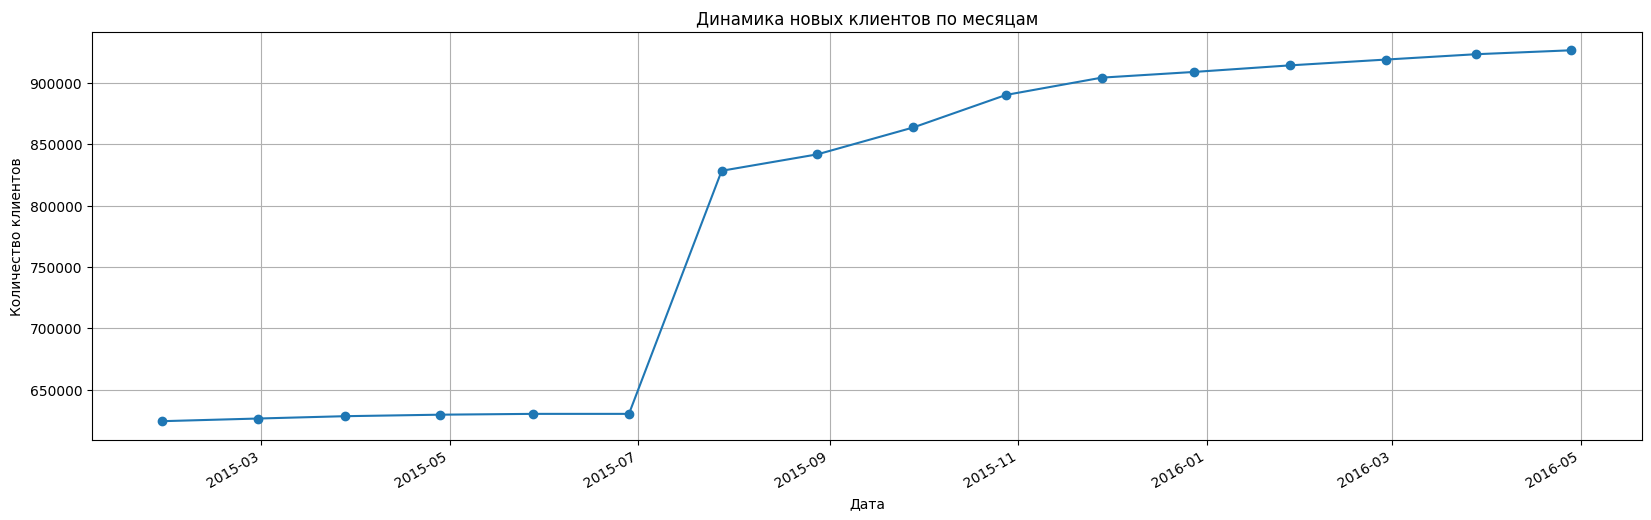

In [13]:
df.groupby('fetch_date')['id'].nunique().plot.line(marker = 'o')

plt.title('Динамика новых клиентов по месяцам')
plt.xlabel('Дата')
plt.ylabel('Количество клиентов')
plt.grid(True)

Видим, что после '2015-07-28' произошло некое заметное изменение.  
Оценим баланс продуктовых переменных (к которым относится и таргет).

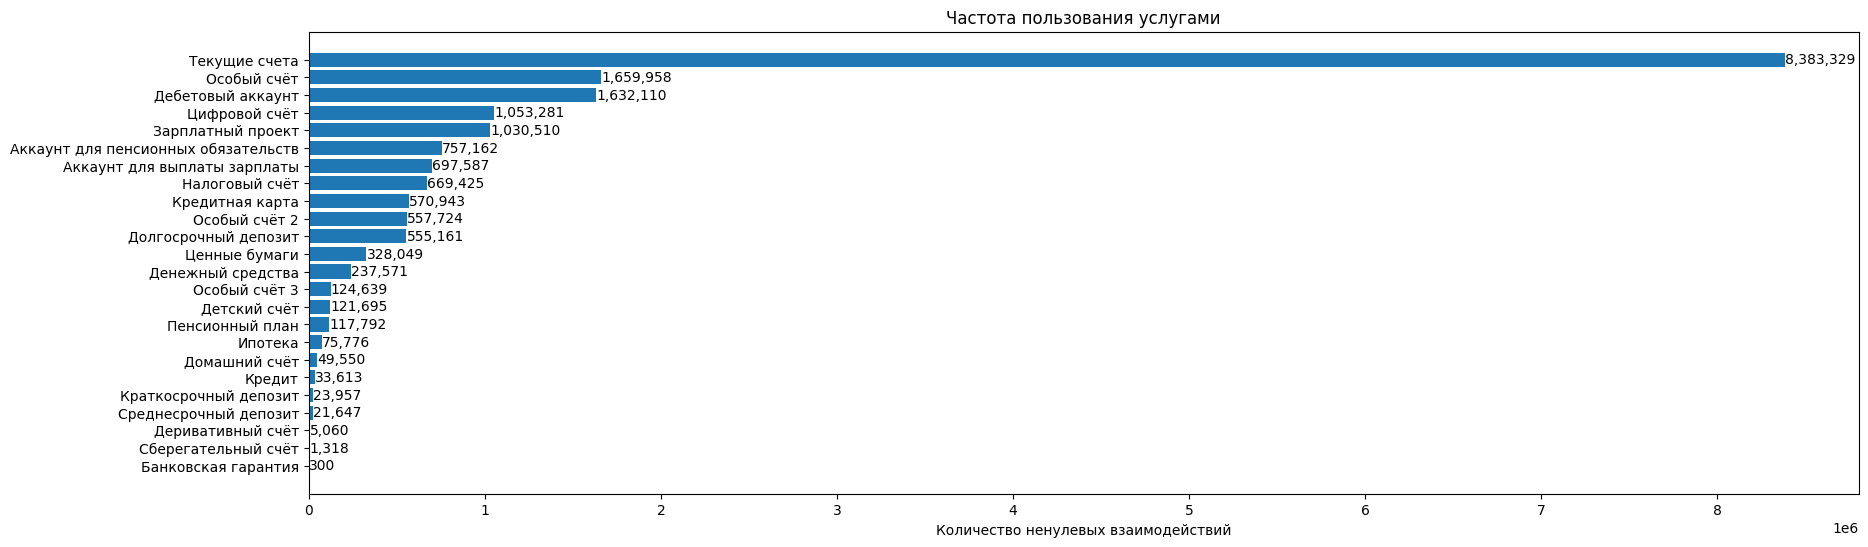

In [14]:
interactions_products = df[product_features].sum().to_frame().sort_values(0)

values = interactions_products[0]
category = interactions_products.index.map(lambda x: interactions_products.attrs[x]['rus'])

plt.figure(figsize=(20,6))
plt.barh(category, values)

for index, value in enumerate(values):
    plt.text(value, index, f"{value:,.0f}", va='center')

plt.xlabel('Количество ненулевых взаимодействий')
plt.title('Частота пользования услугами')
plt.show()

Видим, что периоды пользования разыми продуктами отличаются на несколько порядков.   
Помимо разреженности всех данных, имеется еще и серьезный дисбаланс между признаками.  
Посмотрим на динамику приобретения клиентами продуктов.

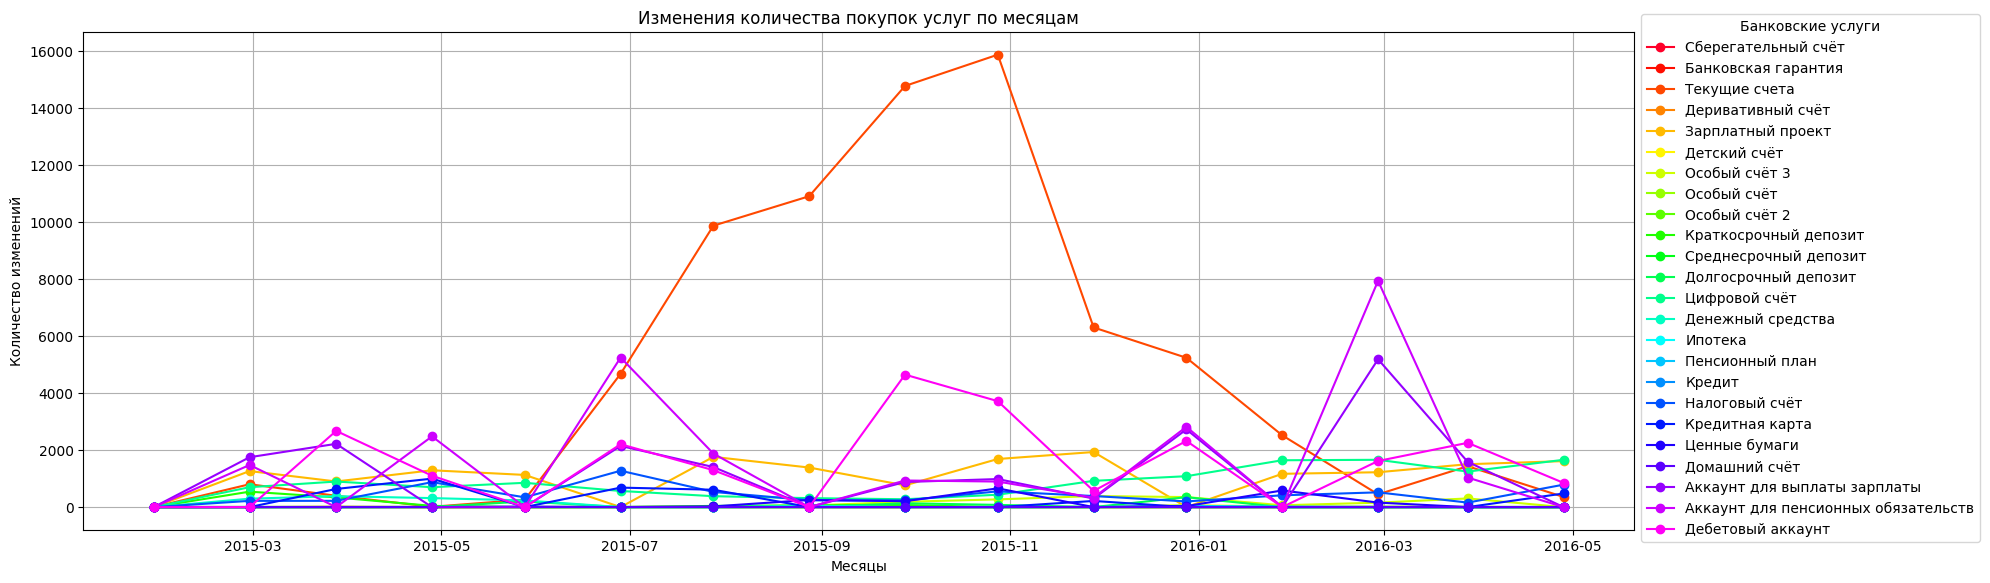

In [15]:
df_targets = df[['fetch_date'] + product_features].set_index('fetch_date')

increments_df = df_targets.groupby('fetch_date').sum().diff().fillna(0) 
increments_df = increments_df[increments_df > 0].fillna(0)

plt.figure(figsize=(20, 6))

num_colors = increments_df.shape[1]
cmap = plt.colormaps.get_cmap('gist_rainbow')

for i, column in enumerate(increments_df.columns):
    color = cmap(i / num_colors) 
    plt.plot(increments_df.index, increments_df[column], marker='o', color=color, label=df.attrs[column]['rus'])

plt.title('Изменения количества покупок услуг по месяцам')
plt.xlabel('Месяцы')
plt.ylabel('Количество изменений')
plt.legend(title='Банковские услуги', bbox_to_anchor=(1, 1.05), loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

del df_targets

Отсюда можно сделать вывод, что явной сезонности или долгосрочного тренда не наблюдается.  Возможно, поменялся размах значений новых покупок в связи с увеличением количества пользователей.  
  
Оценим структуру пропусков.

<b>Комментарий от ревьюера v1</b>
<div class="alert alert-block alert-success">
    
✔️ Отличная визуализация и выводы!
</div>

In [16]:
nan_counts = df.isna().sum(axis=1)

print(f"Распределение количества NaNs:")
display(nan_counts.value_counts().to_frame())
print(f"Количество строк с NaN > 10: {(nan_counts > 10).sum()}")

Распределение количества NaNs:


,count
2,10091442
3,2366991
7,82679
5,72417
6,31911
4,22775
20,10772
22,9931
1,1737
9,9


Количество строк с NaN > 10: 20703


Строки с большим количеством пропусков (> 10) можно удалить.

In [17]:
display_nans_history(df.loc[nan_counts < 10], 'client_segment')

Пропущенные значения в столбце client_segment (Сегментация)


,fetch_date,count,nan_sum
,2015-01-28,"618,433",71
,2015-02-28,"621,391",63
,2015-03-28,"624,064",54
,2015-04-28,"626,046",29
,2015-05-28,"628,338",22
,2015-06-28,"630,242",7
,2015-07-28,"809,460","18,976"
,2015-08-28,"825,251","16,597"
,2015-09-28,"838,367","25,377"
,2015-10-28,"860,124","30,122"


На примере признака 'client_segment' видно изменение динамики пропусков после замеченного нами изменения датасета '2015-07-28'.  
Произошло присоединение большого количества клиентов с повышенным содержанием пропущенных данных.  
Общая картина пропусков некритическая - большинство строк с пропусками имеют 2-3 NaN, которые относятся к упомянутым ранее переменным last_date_as_primary, ind_spouse_employee, income.  

In [18]:
print(f"Количество пропущенных значений переменной 'last_date_as_primary' "
      f"({df.attrs['last_date_as_primary']['rus']}): "
      f"{df['last_date_as_primary'].isna().sum() / len(df) :.2%}")
print(f"Количество пропущенных значений переменной 'ind_spouse_employee' "
      f"({df.attrs['ind_spouse_employee']['rus']}): "
      f"{df['ind_spouse_employee'].isna().sum() / len(df) :.2%}")
print(f"Уникальные значения переменной 'address_type' "
      f"({df.attrs['address_type']['rus']}): "
      f"NaN: {df['address_type'].isna().sum() / len(df) :.2%}, '1.0': "
      f"{df['address_type'].value_counts().loc[1.0] / len(df) :.2%}")

print(f"Самое частое значение переменной 'ind_employee' "
      f"({df.attrs['ind_employee']['rus']}): "
      f"'N': {df['ind_employee'].value_counts()['N'] / len(df) :.2%}")

print(f"Количество пропущенных значений переменной 'gender' ({df.attrs['gender']['rus']}): "
        f"{df['gender'].isna().sum() / len(df) :.4%}")

print(f"Уникальные значения переменной 'country_of_residence' ({df.attrs['country_of_residence']['rus']}): "
        f"'ES': {df['country_of_residence'].value_counts().loc['ES'] / len(df):.2%}, все остальные: {len(df[df['country_of_residence'] != 'ES']) / len(df):.2%}")
print(f"Уникальные значения переменной 'ind_resident' ({df.attrs['ind_resident']['rus']}): "
        f"'S': {df['ind_resident'].value_counts().loc['S'] / len(df):.2%}, все остальные: {df['ind_resident'].value_counts().loc['N'] / len(df):.2%}")

Количество пропущенных значений переменной 'last_date_as_primary' (Последняя дата, когда клиент был премиальным): 99.96%
Количество пропущенных значений переменной 'ind_spouse_employee' (Признак супруга работника): 99.99%
Уникальные значения переменной 'address_type' (Тип адреса): NaN: 0.16%, '1.0': 99.84%
Самое частое значение переменной 'ind_employee' (Статус занятости): 'N': 99.77%
Количество пропущенных значений переменной 'gender' (Пол): 0.1636%
Уникальные значения переменной 'country_of_residence' (Страна резидентства): 'ES': 99.35%, все остальные: 0.65%
Уникальные значения переменной 'ind_resident' (Если страна проживания совпадает со страной банка): 'S': 99.35%, все остальные: 0.49%


Как видим, last_date_as_primary, ind_spouse_employee, address_type даже в усеченном датасете неинформативны.  
Также мало информативны country_of_residence, ind_resident, т.к. все клиенты - граждане этой страны.  
  
Посмотрим на значения некоторых категориальных признаков.

In [19]:
print(df.attrs['age']['rus'])
print(
    df['age'][df['age'] != ' NA']
    .apply(int)
    .describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.99])
    .to_frame()['age']
    .apply(lambda x: f"{x:.0f}")
)

Возраст
count    12669961
mean           40
std            17
min             2
10%            22
25%            24
50%            39
75%            50
99%            88
max           164
Name: age, dtype: object


Возраст не вызывает больших замечаний, теоретически могут быть клиенты и в 116 лет, да и в 2 года иметь счета в Испании не запрещено.

In [20]:
print(df.attrs['client_type_1m']['rus'])
print(df['client_type_1m'].value_counts(dropna=False))

Тип клиента в начале месяца
client_type_1m
1.0     8513284
1       4036454
None     135095
3.0        2349
3          1254
P           773
2.0         673
2           513
4.0         195
4            74
Name: count, dtype: int64


In [21]:
print(df.attrs['client_activity_1m']['rus'])
print(df['client_activity_1m'].value_counts(dropna=False))

Тип клиента в начале месяца
client_activity_1m
I       6763907
A       5787017
None     135095
P          3872
R           769
N             4
Name: count, dtype: int64


Перечисленные категориальные переменные несбалансированы, а также требуется приведение типов.

In [22]:
print(f"{df.attrs['province_code']['rus']}")
print(df['province_code'].unique())
print()
print(f"{df.attrs['province_name']['rus']}")
print(df['province_name'].unique())

Код провинции (адреса клиента)
[29. 13. 50. 45. 24. 20. 10. 17. 49.  8. 37.  9. 22. 31.  5. 40. 27. 25.
 28.  3. 42. 41. 39.  7. 47. 36. 46. 44. 15. 32. 23. 16. 48. 12. 26.  2.
  6. 30. 11. nan  4. 19. 34. 35. 14. 21. 18. 33. 38. 52. 43.  1. 51.]

Имя провинции
['MALAGA' 'CIUDAD REAL' 'ZARAGOZA' 'TOLEDO' 'LEON' 'GIPUZKOA' 'CACERES'
 'GIRONA' 'ZAMORA' 'BARCELONA' 'SALAMANCA' 'BURGOS' 'HUESCA' 'NAVARRA'
 'AVILA' 'SEGOVIA' 'LUGO' 'LERIDA' 'MADRID' 'ALICANTE' 'SORIA' 'SEVILLA'
 'CANTABRIA' 'BALEARS, ILLES' 'VALLADOLID' 'PONTEVEDRA' 'VALENCIA'
 'TERUEL' 'CORUÑA, A' 'OURENSE' 'JAEN' 'CUENCA' 'BIZKAIA' 'CASTELLON'
 'RIOJA, LA' 'ALBACETE' 'BADAJOZ' 'MURCIA' 'CADIZ' None 'ALMERIA'
 'GUADALAJARA' 'PALENCIA' 'PALMAS, LAS' 'CORDOBA' 'HUELVA' 'GRANADA'
 'ASTURIAS' 'SANTA CRUZ DE TENERIFE' 'MELILLA' 'TARRAGONA' 'ALAVA' 'CEUTA']


'province_code' и 'province_name' - признаки, означающие одно и то же, один из них - лишний.   
  
Посмотрим на переменную 'income'.

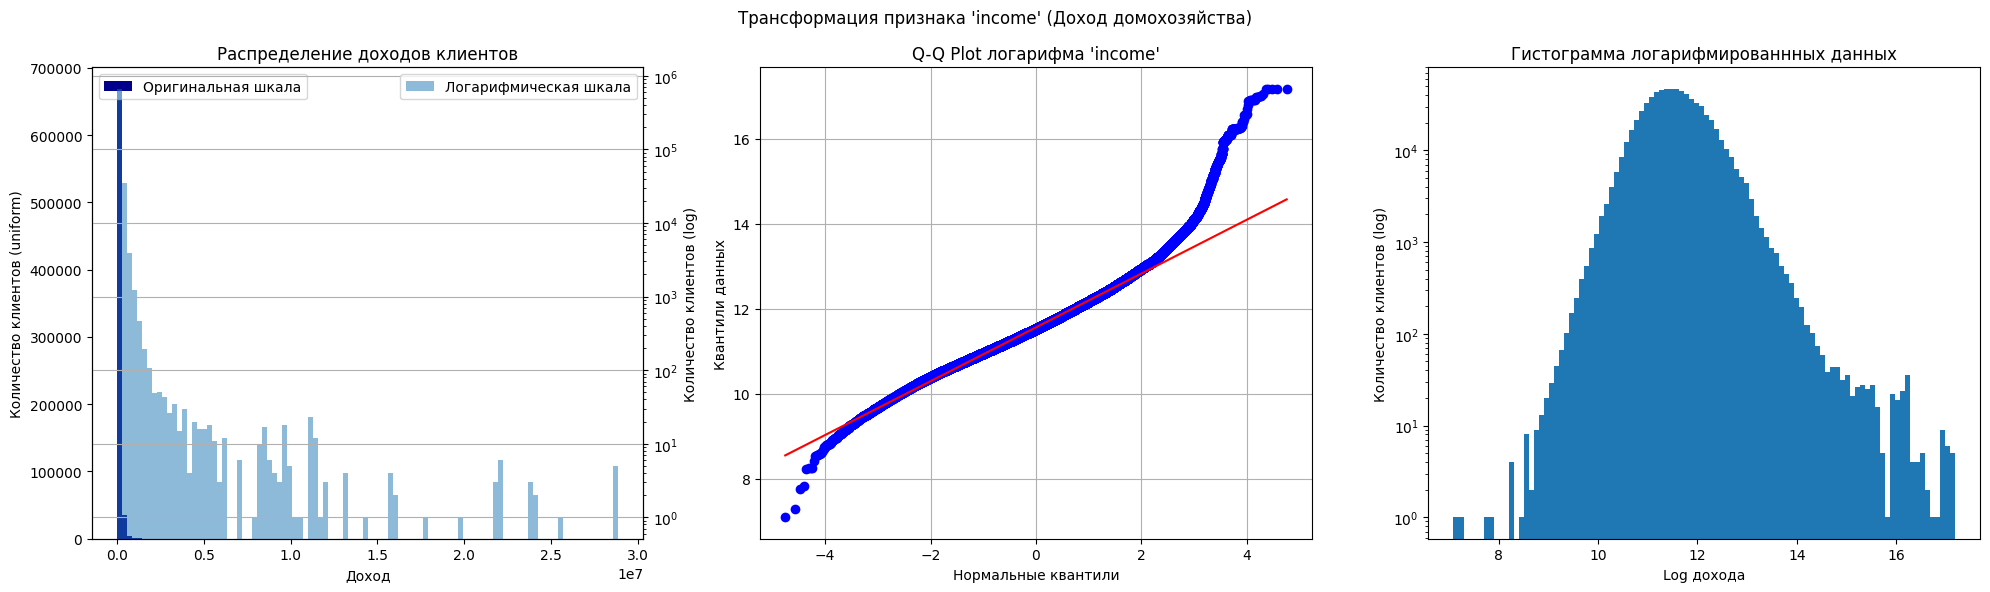

In [23]:
df_incomes = df.groupby('id')['income'].last()

fig, ax = plt.subplots(nrows=1, ncols= 3, figsize=(20, 6))
plt.suptitle(f"Трансформация признака 'income' ({df.attrs['income']['rus']})")

plt.subplot(131)

plt.hist(df_incomes, bins=100, color='darkblue', label = 'Оригинальная шкала')
plt.title('Распределение доходов клиентов')
plt.xlabel('Доход')
plt.ylabel('Количество клиентов (uniform)')
plt.legend(loc='upper left')

plt.twinx()
plt.hist(df_incomes, bins=100, alpha=0.5, label = 'Логарифмическая шкала')
plt.yscale('log')
plt.ylabel('Количество клиентов (log)')
plt.grid(True)
plt.legend()

plt.subplot(132)

income_log = np.log(df_incomes).dropna()

stats.probplot(income_log, dist="norm", plot=plt.subplot(132))
plt.title("Q-Q Plot логарифма 'income'")
plt.xlabel('Нормальные квантили')
plt.ylabel('Квантили данных')
plt.grid(True)

plt.subplot(133)

plt.title('Гистограмма логарифмированнных данных')
plt.xlabel('Log дохода')
plt.ylabel('Количество клиентов (log)')
plt.hist(income_log, bins=100, log=True)

plt.tight_layout()
plt.show()

Как и большинство "денежных" признаков (дорогие/дешевые машины/квартиры/доходы) необходимо нормализовать, например, простым логарифмированием, что, конечно, является необязательным для "лесных" алгоритмов.

<b>Комментарий от ревьюера v1</b>
<div class="alert alert-block alert-success">
    
✔️ Верно!
</div>


##### Определение функции для препроцессинга данных

В целом, у нас сложилось представление, как предобработать данные.  
Средствами pandas проводятся стандартные преобразования:  
 - удаление строк с количеством пропусков более 10
 - фильтрация по признаку актульных клиентов ('ind_deceased' != 'N')
 - обновление 'tenure_months' на основе 'registration_date' 
 - создание двух временных признаков, отражающих временную динамику: 'fetch_month', 'fetch_year'
 - создание признака, отражающего пользование клиентом продуктами банка - количество купленных продуктов 'number_of_products'
 - замена пропусков в 'income' средним значением
 - преобразование типов категорий
 - удаление неинформативных признаков
  
Надо отметить, что поскольку у нас данные разрежены со всех сторон (редкие события и дисбаланс продуктов), возможно, можно было бы глубже поисследовать малоинформативные признаки.  Но, поскольку акцент задания делается на построении сервиса, то этими данными мы можем пренебречь.


<b>Комментарий от ревьюера v1</b>
<div class="alert alert-block alert-success">
    
✔️ ОК!
</div>


In [24]:
def process_na(df: pd.DataFrame) -> pd.DataFrame:
    """
    Process the dataframe by removing rows with too many NaN values and those marked as deceased.

    Parameters:
    df (pd.DataFrame): The input dataframe to process.

    Returns:
    pd.DataFrame: The cleaned dataframe with fewer NaN values and no deceased individuals.
    """
    # Keep rows where fewer than 10 NaN values exist and where 'ind_deceased' is 'N'
    df = df[df.isna().sum(axis=1) < 10]
    df = df[df['ind_deceased'] == 'N']
    
    return df


def process_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Perform various transformations on the dataframe, such as calculating the number of products, 
    tenure in months, and filling in missing values.

    Parameters:
    df (pd.DataFrame): The input dataframe to transform.

    Returns:
    pd.DataFrame: The transformed dataframe with calculated features and cleaned data.
    """
    # Calculate the number of products based on columns starting with 'ind_1m_'
    df['number_of_products'] = df[[col for col in df.columns if col.startswith('ind_1m_')]].sum(axis=1)

    # Extract year and month from the 'fetch_date' column
    df['fetch_year'] = df['fetch_date'].dt.year
    df['fetch_month'] = df['fetch_date'].dt.month

    # Calculate tenure in months based on 'fetch_date' and 'registration_date'
    df['tenure_months'] = (
        (df['fetch_date'].dt.year - df['registration_date'].dt.year) * 12
        + (df['fetch_date'].dt.month - df['registration_date'].dt.month)
    )

    # Apply a logarithmic transformation to the 'income' column
    df['income'] = np.log(df['income'])

    # Convert 'client_type_1m' to numeric, replacing any 'P' values with 5
    df['client_type_1m'] = pd.to_numeric(df['client_type_1m'], errors='coerce').replace('P', 5)

    # Map 'client_segment' to numeric values, with a default of 0 for missing values
    df['client_segment'] = df['client_segment'].map({None: 0, '02 - PARTICULARES': 2, '03 - UNIVERSITARIO': 3, '01 - TOP': 1})

    # Fill missing values in specified columns with provided values
    df.fillna({
        'province_code': 0,
        'gender': 'V',
        'client_activity_1m': 'N',
        'entry_channel': 'UNK',
        'income': df['income'].median(),
        'client_type_1m': 0
    }, inplace=True)

    # Convert specified columns to integer type
    columns_to_int = ['age', 'tenure_months', 'ind_new_client', 'client_relationship_status',
                      'ind_client_activity', 'province_code', 'client_type_1m', 'number_of_products']
    df[columns_to_int] = df[columns_to_int].astype(int)

    # Drop unnecessary columns from the dataframe
    df = df.drop(columns=[
        'fetch_date', 'id', 'ind_deceased', 'ind_spouse_employee', 'last_date_as_primary',
        'address_type', 'ind_employee', 'country_of_residence', 'ind_resident', 
        'province_name', 'registration_date'
    ])

    # Fill any remaining NaN values with 0 and return the dataframe
    return df.fillna(0)

Протестируем созданные функции на текущем датасете.

In [25]:
df = process_na(df)
df = process_df(df)

df.head()

,gender,age,ind_new_client,tenure_months,client_relationship_status,client_type_1m,client_activity_1m,ind_foreigner,entry_channel,province_code,...,target__ind_1m_tax_account,target__ind_1m_credit_card,target__ind_1m_securities,target__ind_1m_home_acc,target__ind_1m_salary_acc,target__ind_1m_pension_obligation_account,target__ind_1m_debit_account,number_of_products,fetch_year,fetch_month
0,H,35,0,0,1,1,A,N,KHL,29,...,0,0,0,0,0,0,0,1,2015,1
1,V,23,0,29,1,1,I,S,KHE,13,...,0,0,0,0,0,0,0,1,2015,1
2,V,23,0,29,1,1,I,N,KHE,13,...,0,0,0,0,0,0,0,1,2015,1
3,H,22,0,29,1,1,I,N,KHD,50,...,0,0,0,0,0,0,0,1,2015,1
4,V,23,0,29,1,1,A,N,KHE,50,...,0,0,0,0,0,0,0,1,2015,1


И выведем оставшиеся категориальные признаки, отметив отсутствие пропусков.

In [26]:
features = [col for col in df.columns if not col.startswith('ind_1m_') and col not in targets]

display_statistics(df[features])

,type,types,count,NaNs,zero_values,nunique,unique-top5
gender,object,{str},12637929,0,0,2,"{'V': 6886565, 'H': 5751364}"
age,int64,{int64},12637929,0,0,120,"{23: 729497, 22: 687881, 24: 683420, 21: 62873..."
ind_new_client,int64,{int64},12637929,0,11869959,2,"{0: 11869959, 1: 767970}"
tenure_months,int64,{int64},12637929,0,135782,256,"{6: 169123, 5: 168227, 4: 165932, 17: 156821, ..."
client_relationship_status,int64,{int64},12637929,0,0,2,"{1: 12632663, 99: 5266}"
client_type_1m,int64,{int64},12637929,0,115165,5,"{1: 12517707, 0: 115165, 3: 3602, 2: 1186, 4: ..."
client_activity_1m,object,{str},12637929,0,0,5,"{'I': 6750921, 'A': 5767972, 'N': 114396, 'P':..."
ind_foreigner,object,{str},12637929,0,0,2,"{'N': 12041346, 'S': 596583}"
entry_channel,object,{str},12637929,0,0,161,"{'KHE': 3800961, 'KAT': 3044672, 'KFC': 288835..."
province_code,int64,{int64},12637929,0,61665,53,"{28: 4090478, 8: 1181550, 46: 631926, 41: 5625..."


##### Обзор зависимостей между признаками и таргетом с помощью средств phik, оценка высококардинальных переменных

In [27]:
numerical_features = ['age', 'tenure_months', 'income', 'fetch_year', 'fetch_month', 'number_of_products']

category_features = ['gender', 'ind_new_client', 'client_relationship_status', 'client_type_1m',
       'client_activity_1m', 'ind_foreigner', 'entry_channel', 'province_code', 'ind_client_activity', 'client_segment']

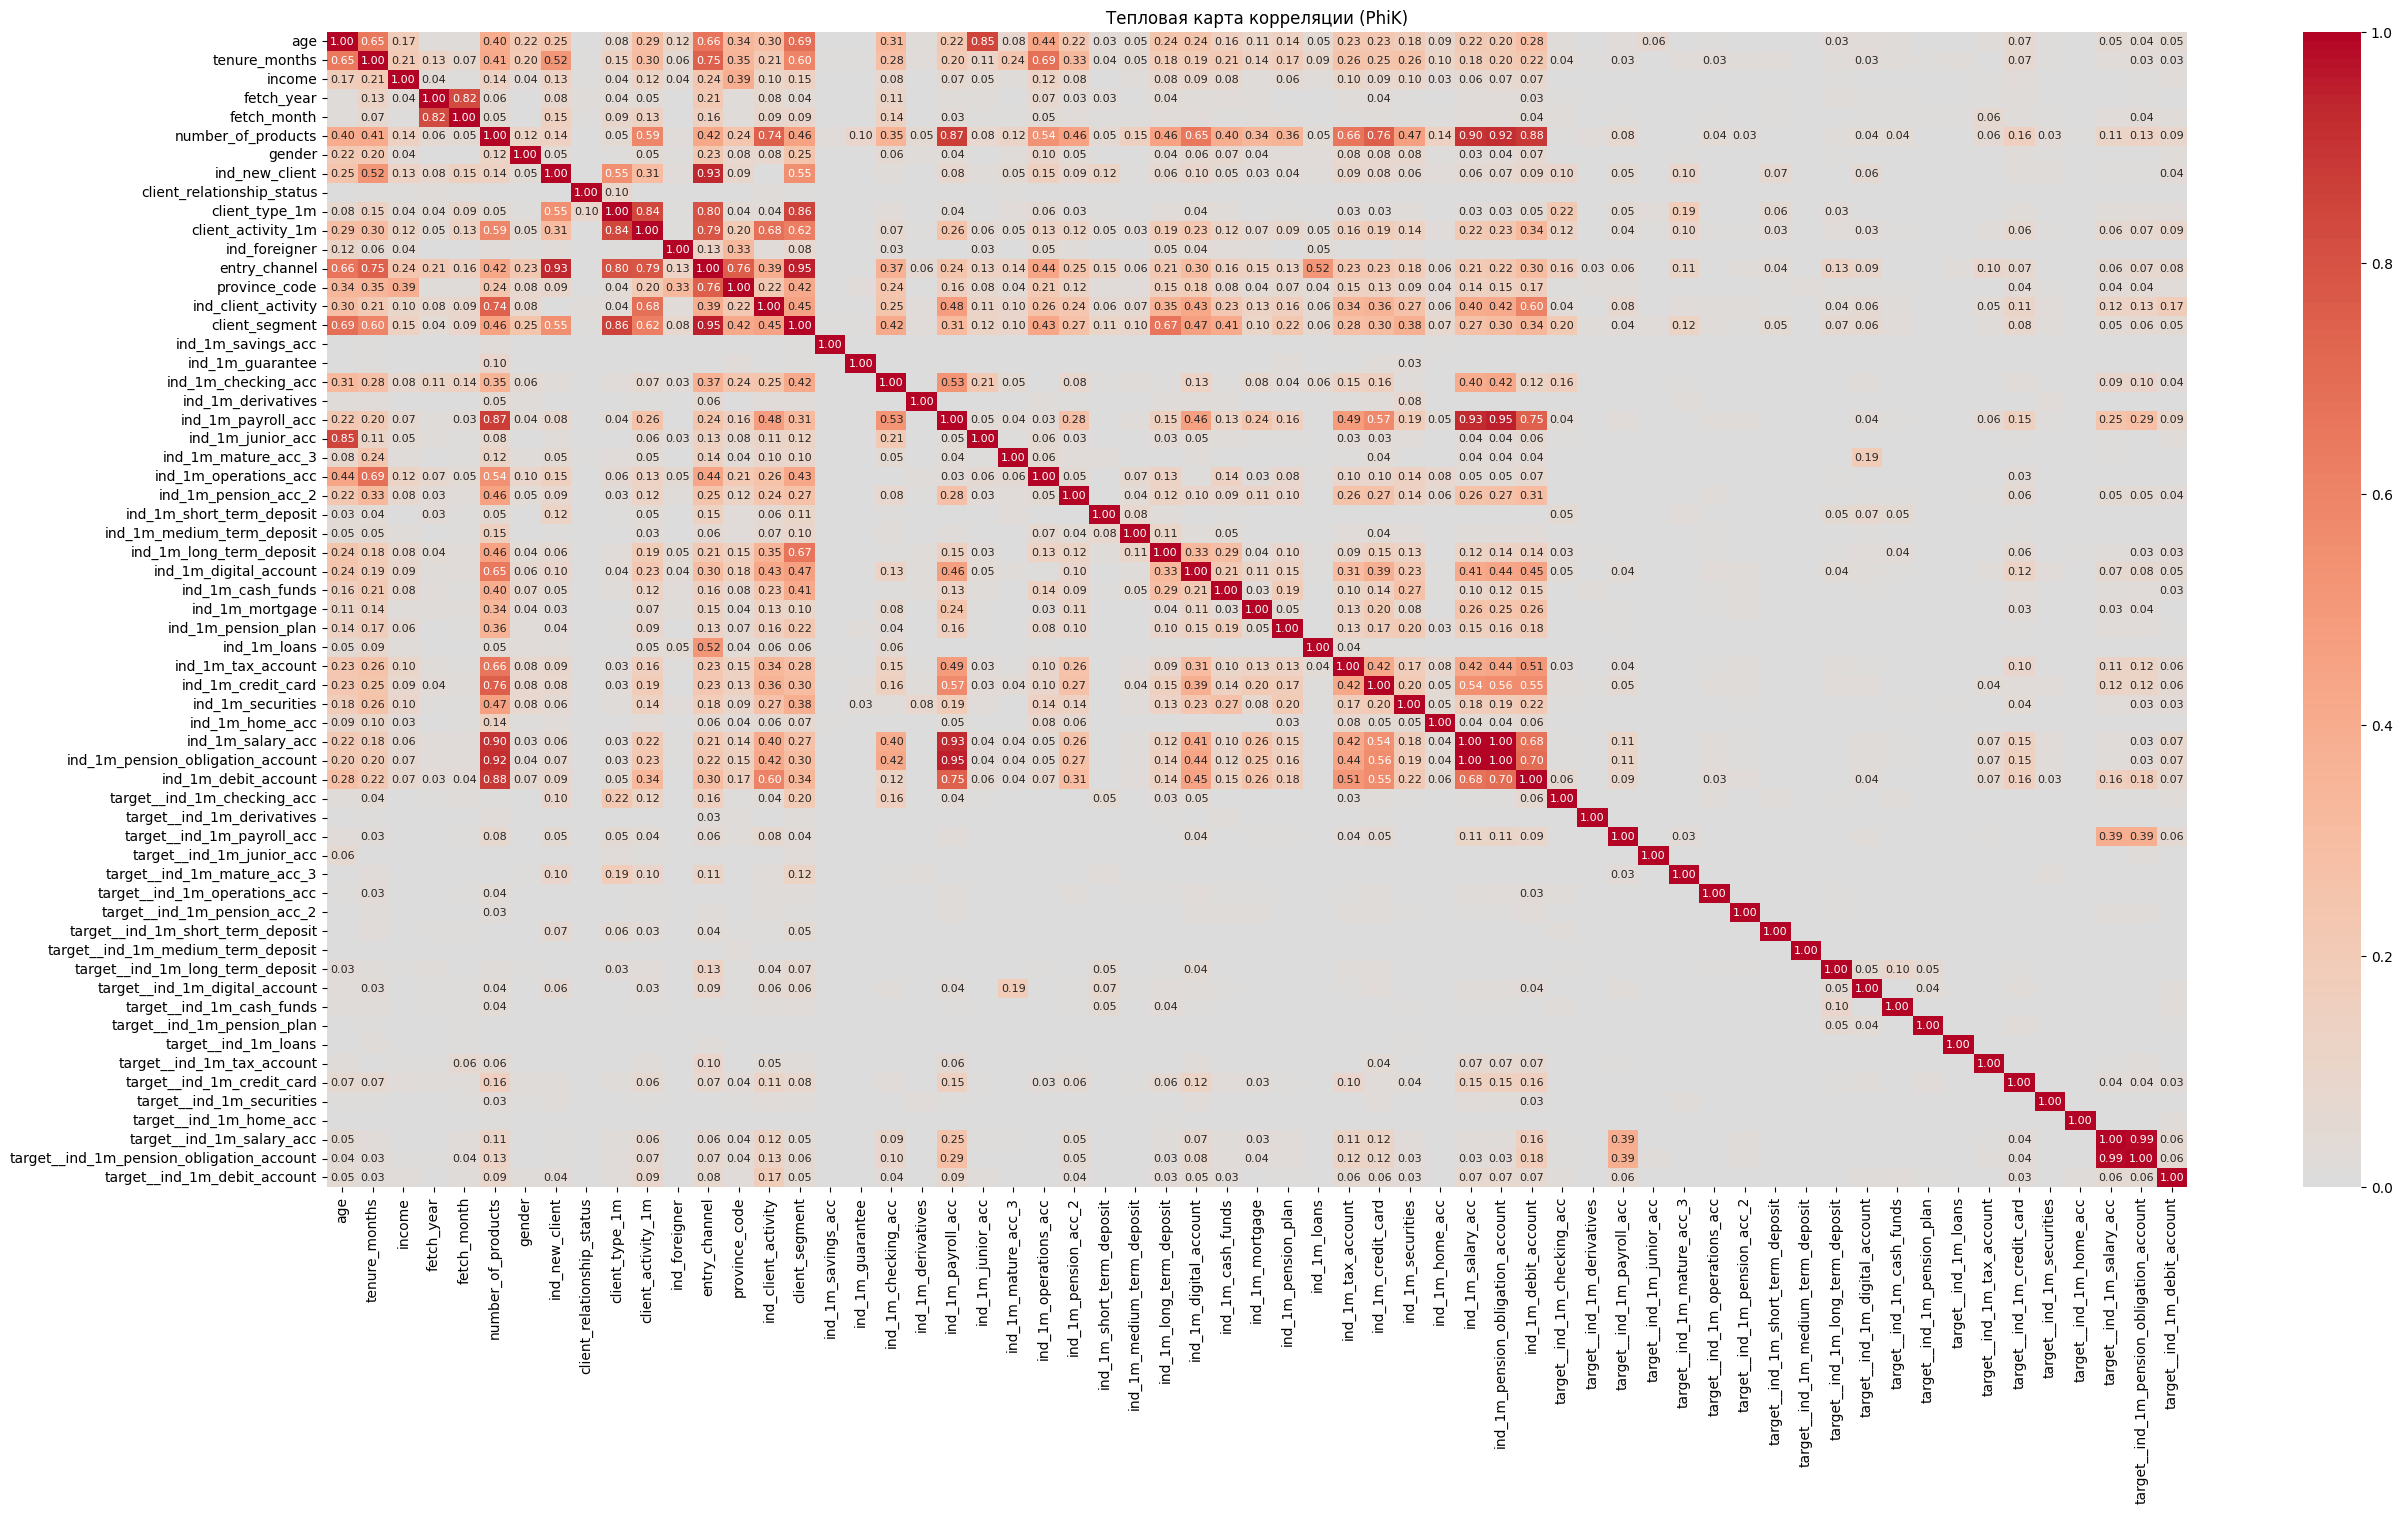

In [28]:
warnings.filterwarnings('ignore')

SAMPLE_SIZE = 10**5
DISPLAY_THRESHOLD = 0.03

phik_matrix = (
    df[numerical_features + category_features + product_features + targets]
    .sample(SAMPLE_SIZE, random_state=RANDOM_STATE)
    .phik_matrix(interval_cols=numerical_features)
)
annot_matrix = phik_matrix.copy().applymap(lambda v: f'{v:.2f}' if v > DISPLAY_THRESHOLD else '')

plt.figure(figsize=(30,15))
sns.heatmap(phik_matrix, cmap='coolwarm', center=0, annot=annot_matrix, fmt='', annot_kws={"size": 8})
plt.title('Тепловая карта корреляции (PhiK)')

plt.show()

Наши индикаторы влияют на таргеты слабо.  Сами таргеты друг от друга почти не зависят.  
Есть сильно влияющие признаки ('client_segment', 'entry_channel'), хорошо объяснимые (группа клиентов, канал привлечения (возможно, рекламная кампания)).  Влияние пол, как часто бывает, на этой диаграмме не проявляется.

Отметим еще пару дисбалансов:  
 - в сильно влияющем признаке 'entry_channel'  
 - и в слабо влияющем 'province_code'

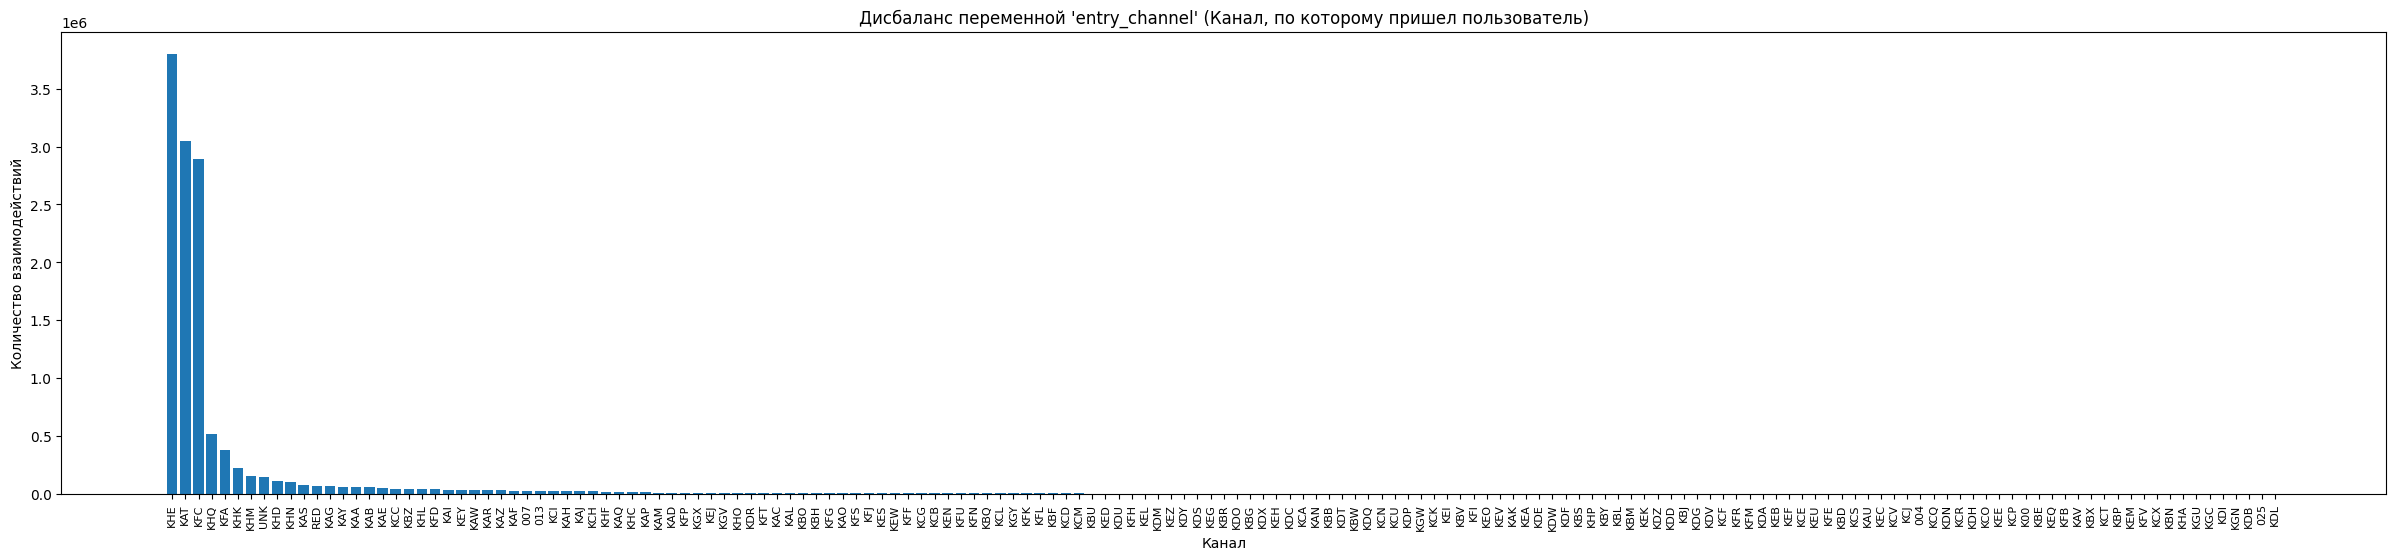

In [29]:
grouped = df.groupby('entry_channel').size().sort_values(ascending=False)

plt.figure(figsize=(30, 6))
plt.title(f"Дисбаланс переменной 'entry_channel' ({df.attrs['entry_channel']['rus']})")
plt.xlabel("Канал")
plt.ylabel("Количество взаимодействий")
plt.xticks(rotation=90, fontsize=8)
plt.bar(grouped.index, grouped.values)
plt.show()

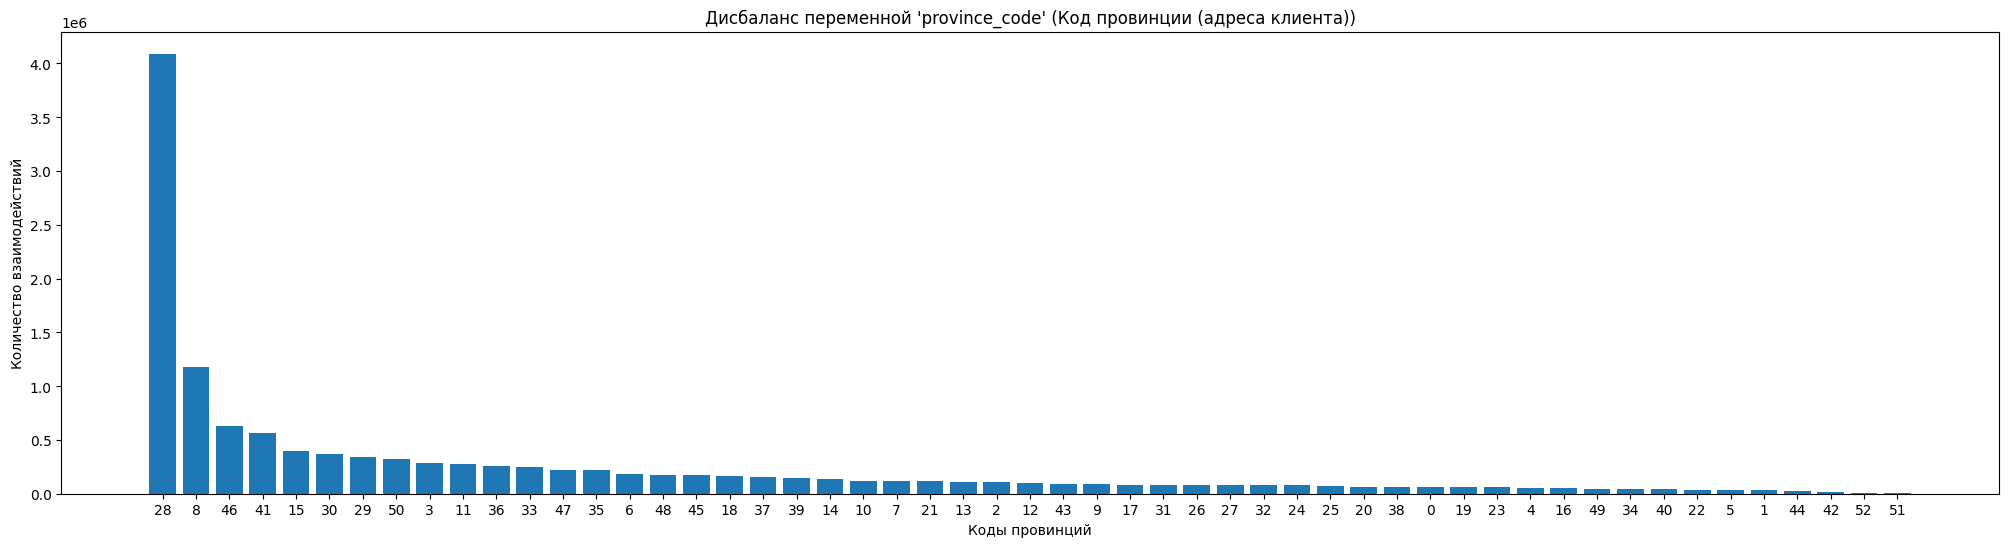

In [30]:
grouped = df.groupby('province_code', observed=True).size().sort_values(ascending=False)

plt.figure(figsize=(25, 6))
plt.title(f"Дисбаланс переменной 'province_code' ({df.attrs['province_code']['rus']})")
plt.xlabel("Коды провинций")
plt.ylabel("Количество взаимодействий")
bars = plt.bar(grouped.index.astype(str), grouped.values)

plt.show()

Принимая во внимание высокую кардинальность переменных и их сильный дисбаланс, выберем кодирование категорий по их частоте в датасете, тогда мы получим один-единственный числовой признак.

##### Проверка препроцессинга, формирование шага предобработки общего пайплайна

Проверим наши функции предобработки, встроив их в step пайплайна и загрузив заново необработанные данные.

In [31]:
# Custom transformer class for preprocessing data, compatible with scikit-learn pipelines
class DataFrameProcessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Constructor method (can be used to initialize parameters if needed)
        pass

    # The fit method is required in scikit-learn compatible classes
    # This method does nothing here, as we are not "fitting" anything to the data
    def fit(self, X, y=None):
        return self  # Return self to maintain compatibility with scikit-learn API

    # The transform method applies the transformations to the input data (X)
    def transform(self, X, y=None):
        # Process the input DataFrame X using a custom function 'process_df'
        # 'X.copy()' is used to avoid modifying the original DataFrame
        processed_X = process_df(X.copy())
        
        # If target labels 'y' are provided (for supervised tasks), align them with the transformed data
        if y is not None:
            # Align the target labels 'y' to match the index of the processed DataFrame 'processed_X'
            processed_y = y.loc[processed_X.index]
            # Return both the processed feature data and the aligned target labels
            return processed_X, processed_y
        
        # If no 'y' is provided (unsupervised tasks), return only the processed feature data
        return processed_X

In [32]:
numerical_columns = ['age', 'tenure_months', 'income', 'fetch_year', 'fetch_month', 'number_of_products']
freq_encode_columns = ['entry_channel', 'province_code']
one_hot_columns = ['gender', 'client_type_1m', 'client_activity_1m', 'ind_foreigner', 'client_segment']

<div class="alert alert-block alert-info">
<b>Комментарий студента v1: </b>   

Закомментировал, т.к. тут 'тяжелые' переменные и не очень значащая проверка.  
</div>

In [33]:
'''
df = pd.read_parquet(TRAIN_PARQUET)

X = df.drop(columns=df.attrs['target__'])
X = process_na(X)

processed_df = DataFrameProcessor().fit_transform(X)

numerical_columns = ['age', 'tenure_months', 'income', 'fetch_year', 'fetch_month', 'number_of_products']
freq_encode_columns = ['entry_channel', 'province_code']
one_hot_columns = ['gender', 'client_type_1m', 'client_activity_1m', 'ind_foreigner', 'client_segment']

display('numerical_columns:', display_statistics(processed_df[numerical_columns]))
display('freq_encode_columns:', display_statistics(processed_df[freq_encode_columns]))
display('one_hot_columns:', display_statistics(processed_df[one_hot_columns]))

del df, X, processed_df
'''

"\ndf = pd.read_parquet(TRAIN_PARQUET)\n\nX = df.drop(columns=df.attrs['target__'])\nX = process_na(X)\n\nprocessed_df = DataFrameProcessor().fit_transform(X)\n\nnumerical_columns = ['age', 'tenure_months', 'income', 'fetch_year', 'fetch_month', 'number_of_products']\nfreq_encode_columns = ['entry_channel', 'province_code']\none_hot_columns = ['gender', 'client_type_1m', 'client_activity_1m', 'ind_foreigner', 'client_segment']\n\ndisplay('numerical_columns:', display_statistics(processed_df[numerical_columns]))\ndisplay('freq_encode_columns:', display_statistics(processed_df[freq_encode_columns]))\ndisplay('one_hot_columns:', display_statistics(processed_df[one_hot_columns]))\n\ndel df, X, processed_df\n"

Настроим стандартную обработку числовых данных, MinMaxScaler - для получения только положительных значений.  
One-hot encoder - для остальных категорий.  
Частотное кодирование - для вышеупомянутых высококардинальных признаков.  
И в качестве модели возьмем CatBoost Classifier (CBC).    
Для этого есть несколько причин:   
 - нет явных зависимостей таргетов от большинства признаков, линейные алгоритмы отработают плохо (по крайней мере, для них нужна более тщательная предподготовка)
 - большинство признаков - категориальные, т.е. алгоритм должен рассматривать их комбинации - а это деревья  
 - признаков много - значит нужен быстрый алгоритм (алгоритмы глубокого обучения на данном этапе неприменимы)
 - плюс - нативная возможность CBC самостоятельно обрабатывать категории
  
Поскольку тагретов много, то будем использовать MultiOutputClassifier (Classifier chain медленнее, да и применятся в случае взаимной зависимости таргетов, а у нас они практически независимы).

<div class="alert alert-block alert-info">
<b>Комментарий студента v1: </b>   

Тут я настраиваю Catboost на самостоятельное определение весов классов.  
</div>

In [34]:
def frequency_encoding(X):
    X_copy = X.copy()
    for col in X_copy.columns:
        freq_map = X_copy[col].value_counts(normalize=True).to_dict()
        X_copy[col] = X_copy[col].map(freq_map)
    return X_copy


column_transformer = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_columns),
        ('onehot', OneHotEncoder(drop='first'), one_hot_columns),
        ('freq', FunctionTransformer(frequency_encoding), freq_encode_columns)
    ], 
    remainder='passthrough',
    force_int_remainder_cols=False,
)

model = Pipeline(steps=[
    ('preprocessor', DataFrameProcessor()),
    ('encoder', column_transformer),
    ('model', MultiOutputClassifier(
        CatBoostClassifier(iterations=100, verbose=0, auto_class_weights='Balanced' , random_state=RANDOM_STATE)
    ))
])

os.makedirs(MODEL_DIR, exist_ok=True)

joblib.dump(model, MODEL_PKL)

['models/model.pkl']

Вышеперечисленные методы без изменений вошли в состав py-проекта.

##### Итоги проведения исследовательского анализа

- данные из csv файла загружены успешно
- объем данных большой (~ 1.3*10^7 строк, 48 столбцов), датасет разрежен (50-70% повторяющихся и нулевых данных), у некоторых признаков большое количество пропусков
- созданы таргеты для машинного обучения как покупки клиентами продуктов в следующем месяце
- большинство переменных - категориальные, боолее половины из которых - бинарные
- выбраны метрики для оценки моделирования: Precision, Recall, F1, ROC AUC (micro)
- фильтрование нерелевантных наблюдений сократило объем датасета ((~ 2.3*10^6 строк, ~ 40 столбцов))
- получены зависимости признаков и таргета, эти зависимости неявные и слабые
- создан пайплайн обработки данных - от предобработки до алгоритма ML (Catboost Classifier)
- модель сохранена для дальнейшей работы
- необходимо отметить направления, которых не касался текущий проект:
  - feature engineering, или дизайн признаков. Для повышения качества предсказаний можно генерировать дополнительные признаки из предметной области, т.е. финансовая информация (мы видим только факт покупки продукта, но не можем оценить интенсивность пользования) и дополнительная информация о пользователях. 
  - Кроме того, у нас есть данные о взаимодействиях пользователь-продукт, значит, с помощью, например, алгоритма ALS() можно генерировать матрицы и получить дополнительные признаки от рекомендательных алгоритмов (коллаборативная фильтрация): рекомендации продуктов, рекомендации на основе похожих пользователей/продуктов, рекомендации популярных продуктов. Однако каждая новая переменная добавляет столько новых признаков, сколько у нас продуктов (24), поэтому встает вопрос о сокращении размерности.
  - поскольку влияние признаков на таргет неочевидно, может потребоваться генерация признаков (Featuretools, AutoFeat)
  - также не были сгенерированы  традиционные для time-series признаки (скользящие средние, признаки задержки (lag features), последний купленный продукт, частота использования и т.п.)
  - обработка данных по частям: объем данных может быть большой (у нас он достигал 3*10^8), может потребоваться пакетная или распределенная обработка датасета
  - в проекте не сравнивались различные алгоритмы обучения

<b>Комментарий от ревьюера v1</b>
<div class="alert alert-block alert-success">
    
✔️ Выводы корректные!
</div>


In [35]:
EXPERIMENT_NAME = 'Спринт 6: Проект'
RUN_NAME = "CBC, full target with auto balance"
REGISTRY_MODEL_NAME = 'model_sprint_6_3'

In [36]:
SLEEP_DURATION = 10

def check_mlflow_server(url):
    try:
        response = requests.get(url)
        if response.status_code == 200:
            print("MLflow сервер запущен.")
            return True
        else:
            print("MLflow сервер вернул статус:", response.status_code)
            return False
    except requests.ConnectionError:
        print("Не удалось подключиться к MLflow серверу.")
        return False


# Check if MLflow server is running, and attempt to start if it's not
if not check_mlflow_server(TRACKING_SERVER_CONN):
    try:
        print(f"MLflow сервер не запущен, попытка запуска, порт {MLFLOW_PORT}.")
        with open(os.devnull, 'w') as devnull:
            # Start the MLflow server in the background
            process = subprocess.Popen(MLFLOW_COMMAND, stdout=devnull, stderr=devnull)
            
            # Allow some time for the server to start
            time.sleep(SLEEP_DURATION)

            # Recheck if the server started successfully
            if not check_mlflow_server(TRACKING_SERVER_CONN):
                raise RuntimeError("Не удалось запустить MLflow сервер.")
            else:
                print(f"MLflow сервер успешно запущен на порту {MLFLOW_PORT}.")
    except subprocess.SubprocessError as e:
        raise RuntimeError(f"MLflow сервер не запущен: {e}, остановка выполнения Jupyter.")
else:
    print(f"MLflow сервер уже запущен на порту {MLFLOW_PORT}.")


if check_mlflow_server(TRACKING_SERVER_CONN):
    mlflow.set_tracking_uri(TRACKING_SERVER_CONN)
    mlflow.set_registry_uri(TRACKING_SERVER_CONN)

Не удалось подключиться к MLflow серверу.
MLflow сервер не запущен, попытка запуска, порт 5000.
MLflow сервер запущен.
MLflow сервер успешно запущен на порту 5000.
MLflow сервер запущен.


<b>Комментарий от ревьюера v1</b>
<div class="alert alert-block alert-success">
    
✔️ Отлично! Артефакты залогированы, ты - молодец!
</div>


In [37]:
# Query all runs from the experiment (use experiment_id or experiment_name)
runs = mlflow.search_runs(experiment_names=[EXPERIMENT_NAME])

# Filter for active (RUNNING) runs
active_runs = runs[runs['status'] == 'RUNNING']

if not active_runs.empty:
    print(f"Найдено активных запусков: {len(active_runs)}:")
    for idx, row in active_runs.iterrows():
        print(f"- Run ID: {row['run_id']}, запущен: {row['start_time']}")
else:
    print("Активных запусков нет.")

Найдено активных запусков: 2:
- Run ID: d9884d9a497842a488f8ee858335d891, запущен: 2024-09-24 17:08:28.825000+00:00
- Run ID: 6fe6df0223ee4d65a562c48e8dbd8efa, запущен: 2024-09-24 17:03:36.677000+00:00


In [38]:
# Ends the current MLflow run and logs any final metrics or artifacts. 
# This is necessary to close the active MLflow run, ensuring that it completes properly.
mlflow.end_run()

In [39]:
experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)
if experiment is None:
    experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
else:
    experiment_id = experiment.experiment_id

run = mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id)
print(f"Запуск нового эксперимента с ID: {run.info.run_id}")


Запуск нового эксперимента с ID: 262845dc563040eb8ed21aa9fd962c63


##### Обучение модели

Параметры модели, которую мы построили на предыдущем этапе:  

UPD. CatBoostClassifier(iterations=100, verbose=0, auto_class_weights='Balanced')  
(Ранее было: CatBoostClassifier(iterations=100, verbose=0, class_weights = [1, 4]))

Среди задач проекта нет глубокой оптимизации модели.  
Направление исследований в проекте - организация сервиса, включая анализ данных и метрик. Поэтому здесь не рассматриваются меры по оптимизации модели и ее гиперпараметров. Поскольку датасет разреженный/шумный и несбалансированный, такая оптимизация может дать хорошие результаты для улучшения качества предсказаний, вот основные возможные направления:  
 - feature engineering, о чем было подробнее упомянуто выше
 - настройка весов классов / регуляризации в параметрах модели
 - выбор функции потерь для несбалансированных классов (Focal Loss) и соответствующих метрик, например Top-k Accuracy (см. ниже)
 - методы бутстрапа, в частности, дополнительная выборка ('oversampling') миноритарного класса, анализ полученных метрик
 - перекрестная k-выборка с кросс-валидацией ('repeating k-fold cross-validation'), которая улучшит репрезентативность данных
 - пост-обработка, в частности, настройка пороговых значений ('threshold') для бинарной классификации, в т.ч. отдельно для каждого таргета

Однако все-таки данный проект концентрируется больше на инженерных задачах - сервис, метрики, анализ.  
Поэтому используется конфигурация 'из коробки' с малым количеством итераций на урезанном датасете.

Поэтому получим результат с некоторыми упрощениями:  
 - оставим небольшок количество итераций (100). Исходя из структуры данных, увеличение количества итераций до 500-1000 улучшит результат, но обучение на двух десятках таргетов займет много времени
 - нужно обязательно "утяжелить" миноритарный класс, подбор соотношения - задача дальнейшей оптимизации модели
 - остальные параметры оставим по умолчанию, хотя может быть необходимость настроить параметры деревьев, learning rate и т.д.
 - также усечем тренировочные данные с 14 до 8 месяцев. Так мы сократим время обучения, а также сконцентрируемся на более "свежих" данных.

<b>Комментарий от ревьюера v1</b>
<div class="alert alert-block alert-success">
    
✔️ ОК, принято!
</div>

In [40]:
del df
get_mem_usage()

Общая память: 33.7 GB
Доступная память: 22.3 GB


<div class="alert alert-block alert-info">
<b>Комментарий студента v1: </b>   

Для экономии памяти не использую промежуточные переменные.  
В функциях для краткости (не по-питоновски) использую глобальные переменные targets, product_features etc.
</div>

In [41]:
#df_train = pd.read_parquet(TRAIN_PARQUET)

#df_train = process_na(df_train)
#df_train = df_train[df_train.fetch_date >= START_TRAIN_DATE]

#df_test = pd.read_parquet(TEST_PARQUET)
#df_test = process_na(df_test)

#targets = df_train.attrs['target__']
        
#X_train, y_train = df_train.drop(columns=targets), df_train[targets]
#X_test, y_test = df_test.drop(columns=targets), df_test[targets]

In [42]:
def get_train() -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series]:
    """
    Prepares the training dataset by processing missing values, 
    separating features from targets, and calculating the percentage 
    of users using each product feature.
    
    Returns:
        X_train (pd.DataFrame): Training features.
        y_train (pd.DataFrame): Training target labels.
        sorted_list (pd.Series): Percentage of users using each product feature.
    """
    # Read and process missing values in the training dataset
    df_train = process_na(pd.read_parquet(TRAIN_PARQUET))

    # Split the dataset into features (X_train) and targets (y_train)
    X_train, y_train = df_train.drop(columns=targets), df_train[targets]

    # Group by 'id' for product feature usage
    grouped_by_id = df_train.groupby('id')[product_features]

    # Calculate the total number of unique users
    num_of_users = len(grouped_by_id)

    # Calculate the percentage of users using each product feature
    # (grouped_by_id.sum() != 0) identifies whether the product is used by a user
    # Summing across users and normalizing by the total number of users
    sorted_list = ((grouped_by_id.sum() != 0).sum() / num_of_users * 100).sort_values()

    return X_train, y_train, sorted_list


def get_test() -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Prepares the test dataset by processing missing values
    and separating features from targets.
    
    Returns:
        X_test (pd.DataFrame): Test features.
        y_test (pd.DataFrame): Test target labels.
    """
    # Read and process missing values in the test dataset
    df_test = process_na(pd.read_parquet(TEST_PARQUET))

    # Split the dataset into features (X_test) and targets (y_test)
    X_test, y_test = df_test.drop(columns=targets), df_test[targets]

    return X_test, y_test


# Retrieve the training and test datasets
X_train, y_train, sorted_list = get_train()
X_test, y_test = get_test()

get_mem_usage()

Общая память: 33.7 GB
Доступная память: 19.5 GB


<div class="alert alert-block alert-info">
<b>Комментарий студента v1: </b>   

Раньше оставлял только репрезентативные таргеты (nunique() > 1). Для сокращения времени обучения сейчас оставляю только популярные, где пользователей больше 2% (sorted_list > 2).  
</div>

In [43]:
#target_cols = [col for col in y_train.columns if y_train[col].nunique() > 1]
#number_of_targets = len(target_cols)

In [44]:
target_cols = ['target__' + col for col in sorted_list[sorted_list > 2].index.to_list()]
number_of_targets = len(target_cols)
target_cols

['target__ind_1m_securities',
 'target__ind_1m_pension_acc_2',
 'target__ind_1m_long_term_deposit',
 'target__ind_1m_credit_card',
 'target__ind_1m_tax_account',
 'target__ind_1m_salary_acc',
 'target__ind_1m_pension_obligation_account',
 'target__ind_1m_payroll_acc',
 'target__ind_1m_digital_account',
 'target__ind_1m_operations_acc',
 'target__ind_1m_debit_account',
 'target__ind_1m_checking_acc']

In [45]:
%%time
# ~ 15 min if not fitted

if os.path.exists(FITTED_MODEL):
    model = joblib.load(FITTED_MODEL)
    print(f"Найдена и загружена обученная модель {FITTED_MODEL}")

elif os.path.exists(MODEL_PKL):
    print(f"Найдена необученная модель {MODEL_PKL}, начинаем обучение...", end='')
    
    model = joblib.load(MODEL_PKL)
    model.fit(X_train, y_train[target_cols])
    
    joblib.dump(model, FITTED_MODEL)
    print(f"  Модель обучена и сохранена: {FITTED_MODEL}")
else:
    raise RuntimeError(f"Модель не найдена, остановка выполнения Jupyter.")

Найдена и загружена обученная модель models/fitted_model.pkl
CPU times: user 8.5 ms, sys: 8.13 ms, total: 16.6 ms
Wall time: 61.7 ms


<div class="alert alert-block alert-info">
<b>Комментарий студента v1: </b>   

Посмотрим какие веса должна была расставить модель.  
</div>

In [46]:
for label in target_cols:
    print(f"{label}: {y_train.shape[0] / y_train[label].sum():.0f}")

target__ind_1m_securities: 2709
target__ind_1m_pension_acc_2: 6283
target__ind_1m_long_term_deposit: 2489
target__ind_1m_credit_card: 226
target__ind_1m_tax_account: 1822
target__ind_1m_salary_acc: 177
target__ind_1m_pension_obligation_account: 146
target__ind_1m_payroll_acc: 399
target__ind_1m_digital_account: 417
target__ind_1m_operations_acc: 3890
target__ind_1m_debit_account: 88
target__ind_1m_checking_acc: 215


<div class="alert alert-block alert-info">
<b>Комментарий студента v1: </b>   

Веса высокие, то есть модель сильно настраивается на Recall, следующим шагом было бы разумным попробовать auto_class_weights='SqrtBalanced'
</div>

Получим предсказания и вероятности для метрик.

In [47]:
# ~ 3 min
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

y_true = y_test[target_cols]

<div class="alert alert-block alert-info">
<b>Комментарий студента v1: </b>   

Проделаем формальный расчет порогов.  
</div>

In [48]:
# Function to tune thresholds for each label
def tune_thresholds(y_true: pd.DataFrame, y_proba_list: list, target_cols: list) -> np.ndarray:
    """
    Tune thresholds for each label based on the F1-score using precision-recall curve.

    Parameters:
        y_true (pd.DataFrame): Ground truth binary labels with shape (n_samples, n_labels).
        y_proba_list (list): List of predicted probabilities for each label, where
                             each element is an array of shape (n_samples, 2) with class probabilities.
        target_cols (list): List of target column names.

    Returns:
        np.ndarray: Array of optimal thresholds for each label.
    """
    # Debugging: Check if y_proba_list has the same length as target_cols
    assert len(y_proba_list) == len(target_cols), f"Length mismatch: y_proba_list has {len(y_proba_list)} elements, but target_cols has {len(target_cols)} elements."

    thresholds = []
    for i, label in enumerate(target_cols):
        # Extract probabilities for the positive class (class 1) for label i
        y_proba = y_proba_list[i][:, 1]
        
        # Calculate precision-recall curve for label i
        precision, recall, threshold = precision_recall_curve(y_true[label], y_proba)
        
        # Calculate F1 scores for each threshold
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)  # Add small value to avoid division by zero
        
        # Find the best threshold based on F1 score
        best_threshold = threshold[np.argmax(f1_scores)]
        thresholds.append(best_threshold)
    
    return np.array(thresholds)

# Assuming y_test is a DataFrame, target_cols is a list of relevant target columns, 
# and y_pred_proba is the list of predicted probabilities
y_test = y_test[target_cols]
optimal_thresholds = tune_thresholds(y_test, y_pred_proba, target_cols)

# Apply the optimal thresholds to binarize the predictions
y_pred_optimal = pd.DataFrame(np.zeros_like(y_test), columns=y_test.columns)
for i, label in enumerate(target_cols):
    y_proba = y_pred_proba[i][:, 1]  # Extract positive class probabilities for label i
    y_pred_optimal[label] = (y_proba >= optimal_thresholds[i]).astype(int)

# Evaluate performance using F1-score or other metrics
f1_macro = f1_score(y_test, y_pred_optimal, average='macro')
f1_micro = f1_score(y_test, y_pred_optimal, average='micro')

print(f"F1 Macro: {f1_macro}")
print(f"F1 Micro: {f1_micro}")
print(f"Optimal thresholds: {optimal_thresholds}")


F1 Macro: 0.17114593477225856
F1 Micro: 0.22531564701333198
Optimal thresholds: [0.9108 0.9922 0.9049 0.9395 0.9866 0.9394 0.9281 0.9852 0.9805 0.9958
 0.8927 0.9512]


<div class="alert alert-block alert-info">
<b>Комментарий студента v1: </b>   

Получается обратная картина: пороги выставляются большие, чтобы 'допускать' только очень вероятные значения таргета.  
Высокие пороги нацелилась на 'консервативную стратегию', т.е. минимизации FP, или оставляя в приоритете Precision в ущерб Recall.  
</div>



##### Подготовка функций для встраивания модели в сервис предсказаний

Для мониторинга предсказаний нам потребуются имена таргетов на русском (для FastAPI) и на английском (Graphite принимает только ASCII названия).  
Для обработки часто встречающихся пропусков в 'income' сохраним среднее значение как параметр.

In [49]:
model_params_dict = {
    'target_names': [X_train.attrs[x[len('target__'):]]['rus'] for x in target_cols],
    'target_names_eng': [X_train.attrs[x[len('target__'):]]['eng'] for x in target_cols],
    'income_mean': X_train['income'].mean()
}

with open(MODEL_PARAMS, 'w') as f:
    json.dump(model_params_dict, f)

mlflow.log_artifact(MODEL_PARAMS)

Для тестирования сервиса нам нужно будет генерировать json запросы, а для получения предсказаний нужен DataFrame.
Для этого создадим некоторые функции преобразования, смысл которых понятен из аннотаций.

In [50]:
def safe_strftime(date_value: pd.Timestamp) -> Optional[str]:
    """
    Safely convert a pandas Timestamp to a string in 'dd-mm-yyyy' format.
    If the value is NaT (not a time), return None.

    Parameters:
    - date_value (pd.Timestamp): A timestamp to convert.

    Returns:
    - str or None: The formatted date string or None if the value is NaT.
    """
    if pd.isnull(date_value):  # Check for NaT (Not a Time)
        return None
    return date_value.strftime('%d-%m-%Y')  # Format the date as dd-mm-yyyy


def save_row_to_json(row: pd.Series, json_file: str) -> None:
    """
    Save a pandas Series (row) to a JSON file, converting datetime fields safely.

    Parameters:
    - row (pd.Series): The row of data to save.
    - json_file (str): The path to the JSON file to save the data.

    Returns:
    - None: The function writes the row to a file and doesn't return anything.
    """
    row = row.copy()  # Make a copy of the row to avoid modifying the original
    
    # Safely convert datetime fields to string format
    row[date_columns] = row[date_columns].apply(lambda col: safe_strftime(col))
    
    # Convert the row to JSON format
    json_data = row.to_json(orient='index', indent=4)
    
    # Write the JSON data to the specified file
    with open(json_file, 'w') as f:
        f.write(json_data)


def load_row_from_json(json_file: str) -> pd.DataFrame:
    """
    Load a row from a JSON file and convert it into a pandas DataFrame.
    Handles datetime fields and assigns a mean value to the 'income' column if it's missing.

    Parameters:
    - json_file (str): Path to the JSON file.

    Returns:
    - pd.DataFrame: A DataFrame containing the loaded row.
    """
    # Load the JSON data as a pandas Series
    row_loaded = pd.read_json(json_file, typ='series')
    
    # Convert string dates back into datetime format
    row_loaded[date_columns] = row_loaded[date_columns].apply(pd.to_datetime, format='%d-%m-%Y')

    # Handle missing 'income' value by assigning the mean income
    if row_loaded['income'] is None:
        row_loaded['income'] = income_mean
    
    # Return as a single-row DataFrame
    return pd.DataFrame([row_loaded])


def interpret_predictions(predictions: list, lang: str = 'rus', is_integer=True) -> Dict[str, int]:
    """
    Interpret the model predictions by mapping the prediction columns to target names.

    Parameters:
    - predictions (list): List of predicted values.
    - lang (str): Language for target names, 'rus' for Russian, 'eng' for English.

    Returns:
    - dict: A dictionary mapping target names to predicted values.
    """
    # Select appropriate target names based on language
    if lang == 'rus':
        targets = target_names
    else:
        targets = target_names_eng
    
    # Map the predictions to target names
    if is_integer:
        return {name: int(pred) for pred, name in zip(predictions, targets)}
    
    return {name: pred for pred, name in zip(predictions, targets)}

In [51]:
save_row_to_json(X_test.iloc[LUCKY_USER], SAMPLE_JSON)

prediction = model.predict(load_row_from_json(SAMPLE_JSON))[0]

predictions_dict = interpret_predictions(prediction, lang='rus')

for target, prediction in predictions_dict.items():
    print(target, prediction)

Ценные бумаги 0
Особый счёт 2 0
Долгосрочный депозит 0
Кредитная карта 1
Налоговый счёт 0
Аккаунт для выплаты зарплаты 0
Аккаунт для пенсионных обязательств 0
Зарплатный проект 0
Цифровой счёт 0
Особый счёт 0
Дебетовый аккаунт 0
Текущие счета 1


В итоге мы создали образец json в файле sample.json и получили функцию для вывода предсказаний модели на английском и русском языках.  

Вернемся к оценке предсказаний.

##### Получение и интерпретация метрик  
Первую поверхностную оценку получим, сравнив количества предсказанных и истинных значений

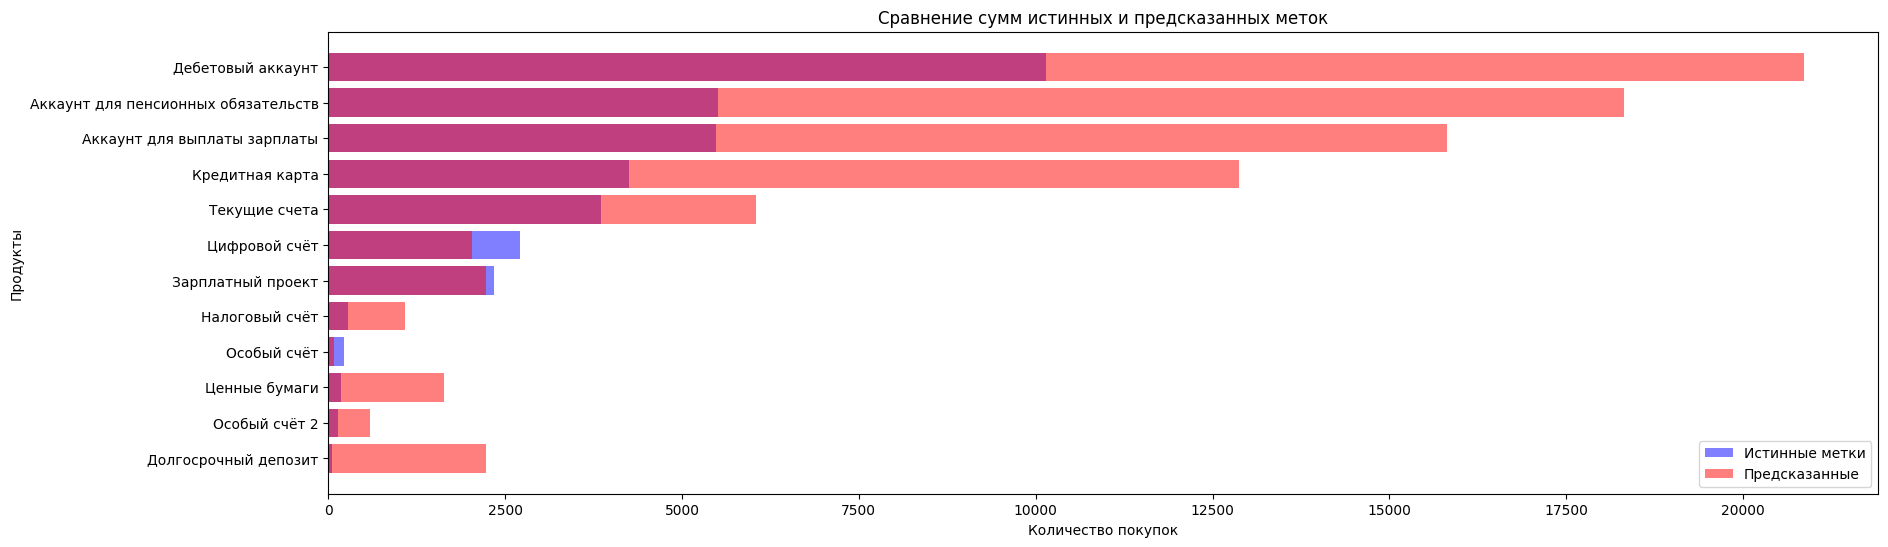

In [52]:
plot_data = pd.DataFrame({
    'True': y_true.sum(axis=0),
    'Predicted': np.sum(y_pred_optimal, axis=0)
})

plot_data_sorted = plot_data.sort_values(by='True')

plt.figure(figsize=(20, 6))
plt.title(f"Сравнение сумм истинных и предсказанных меток")
plt.ylabel("Продукты")
plt.xlabel("Количество покупок")

#y_labels = [df_train.attrs[col[8:]]['rus'] for col in plot_data_sorted.index]
y_labels = [X_train.attrs[col[8:]]['rus'] for col in plot_data_sorted.index]
plt.barh(y_labels, plot_data_sorted['True'], label='Истинные метки', alpha=0.5, color='b')
plt.barh(y_labels, plot_data_sorted['Predicted'], label='Предсказанные', alpha=0.5, color='r')

plt.legend(loc='lower right')

plot_path = "compare_plot.png"
plt.savefig(plot_path)

plt.show()

mlflow.log_artifact(plot_path)
os.remove(plot_path)

Видим, что модель (неглубоко обученная) неплохо собирает положительные таргеты, отличает их друг от друга, но ошибается в частоте предсказаний,  неравномерно недооценивает/переоценивает различные таргеты.  
Залогируем модель, а потом и метрики.

In [53]:
warnings.filterwarnings("ignore", category=UserWarning)

X_test['ind_spouse_employee'] = X_test['ind_spouse_employee'].fillna(0)

mlflow.sklearn.log_model(
    sk_model=model,
    artifact_path='models',
    registered_model_name=REGISTRY_MODEL_NAME,
    signature=mlflow.models.infer_signature(X_test[:10], model.predict(X_test[:10])),
    await_registration_for=60,
    pip_requirements='requirements.txt'
)

mlflow.log_params(model.get_params())

Registered model 'model_sprint_6_3' already exists. Creating a new version of this model...
2024/09/27 10:39:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 60 seconds for model version to finish creation. Model name: model_sprint_6_3, version 2
Created version '2' of model 'model_sprint_6_3'.


<div class="alert alert-block alert-info">
<b>Комментарий студента v1: </b>   

Рассчитаем метрики для модели с автоматической расстановкой весов.  
</div>

In [54]:
# ~ 30 s
metrics = calculate_metrics(y_true, y_pred, y_pred_proba)

display(metrics)

metrics_dict = {
    f'{metric}_{metric_type}': metrics.loc[metric, metric_type]
    for metric in metrics.index
    for metric_type in metrics.columns
}

mlflow.log_metrics(metrics_dict)

,micro,macro,average
Accuracy,-1.0000,-1.0000,0.5808
Precision,0.0274,0.0228,0.0419
Recall,0.8613,0.6703,0.8613
F1,0.0530,0.0434,0.0795
ROC AUC,0.9513,0.9065,0.9367


<div class="alert alert-block alert-info">
<b>Комментарий студента v1: </b>   

Рассчитаем метрики для модели с автоматической расстановкой весов + с рассчитанными оптимальными порогами.
</div>

In [55]:
# ~ 30 s
metrics = calculate_metrics(y_true, y_pred_optimal, y_pred_proba)

display(metrics)

metrics_dict = {
    f'{metric}_{metric_type}': metrics.loc[metric, metric_type]
    for metric in metrics.index
    for metric_type in metrics.columns
}

mlflow.log_metrics(metrics_dict)

,micro,macro,average
Accuracy,-1.0000,-1.0000,0.9262
Precision,0.1599,0.1506,0.2000
Recall,0.3811,0.2534,0.3811
F1,0.2253,0.1711,0.2467
ROC AUC,0.9513,0.9065,0.9367


<div class="alert alert-block alert-info">
<b>Комментарий студента v1: </b>   

В итоге видим классический trade-off между Recall и Precision.
Далее я все оставил без изменений.
</div>

Accuracy высокая из-за преобладающего количества предсказаний мажоритарного класса (0).  
Микро-метрики, то есть усредненные по всем наблюдениям, в целом лучше, чем макро-усредненные по классам, т.к. классы очень разные.  
Высокая ROC-AUC показывает, что модель в среднем отличает класс 1 от класса 0.  
Для разреженных, несбалансированны данных и неоптимизированной модели, удачные предсказания на микро-уровне 23-31% - неплохой результат.

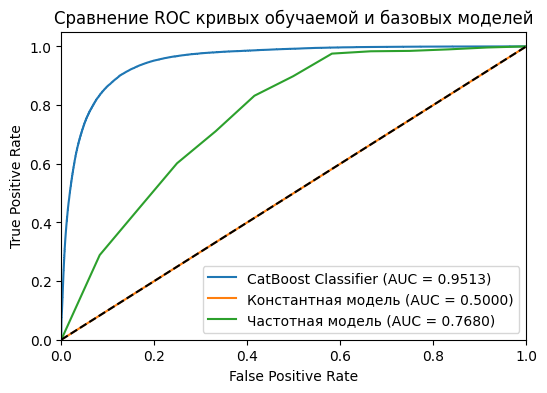

In [56]:
plt.figure(figsize=(6, 4))
y_pred_proba_class_1 = np.array(y_pred_proba)[:, :, 1].T 
plot_roc_curve(y_true, y_pred_proba_class_1, 'CatBoost Classifier')

constant_baseline_proba = np.full(y_true.shape, 0.5)
plot_roc_curve(y_true, constant_baseline_proba, 'Константная модель')

label_frequencies = y_train[target_cols].mean(axis=0)
frequency_based_baseline_proba = np.tile(label_frequencies.values, (y_true.shape[0], 1))
plot_roc_curve(y_true, frequency_based_baseline_proba, 'Частотная модель')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Сравнение ROC кривых обучаемой и базовых моделей')
plt.legend(loc='lower right')
plt.show()

##### Сравнение метрик модели с константными предсказаниями

Как видно из графика, частотная baseline модель может показать высокую ROC AUC, если будет выбирать самые популярные продукты.  
Сравним нашу модель с константными более основательно.  
Попробуем в каждом таргете сохранить средние значения по всем наблюдениям.

In [57]:
#FREQUENCY_THRESHOLD = 0.02
FREQUENCY_THRESHOLD = 0.002

y_train.mean(axis=0)[y_train.mean(axis=0) > FREQUENCY_THRESHOLD]

target__ind_1m_checking_acc                 0.0047
target__ind_1m_payroll_acc                  0.0025
target__ind_1m_digital_account              0.0024
target__ind_1m_credit_card                  0.0044
target__ind_1m_salary_acc                   0.0057
target__ind_1m_pension_obligation_account   0.0068
target__ind_1m_debit_account                0.0113
dtype: float64

In [58]:
# ~ 30 s
n_rows = y_pred.shape[0]
n_columns = y_pred.shape[1]

mean_class_probs = y_train.mean(axis=0)
constant_baseline_proba = np.array([
    np.tile([1 - mean_class_probs.iloc[i], mean_class_probs.iloc[i]], (n_rows, 1)) 
    for i in range(n_columns)
])

y_pred_constant = (constant_baseline_proba[:, :, 1].T > FREQUENCY_THRESHOLD).astype(int)

print("Метрики базовой модели на константных средних")
calculate_metrics(y_true, y_pred_constant, constant_baseline_proba)

# Acc = 0, т.к. не было случаев совпадения предсказаний  по всем меткам сразу (т.е. где 5 выбранных таргетов == 1)

Метрики базовой модели на константных средних


,micro,macro,average
Accuracy,-1.0000,-1.0000,0.0000
Precision,0.0002,0.0000,0.0000
Recall,0.0092,0.1667,0.0092
F1,0.0003,0.0001,0.0000
ROC AUC,0.4368,0.5000,0.5000


Видим, что полнота даже выше, чем у нашей модели, то есть константная модель на средних собирает больше 1, но, к сожалению, точность < 2%.  Тут даже Accuracy == 0, то есть константы не различают классы.  
  
Другая модель пытается сохранить частоту появления положительных предсказаний для каждого таргета.

In [59]:
# ~ 30 s
y_pred_frequency_based = np.zeros_like(y_true)

for i in range(n_columns):
    num_ones = int(y_train.iloc[:, i].mean() * n_rows)
    ones_indices = np.random.choice(n_rows, num_ones, replace=False)
    y_pred_frequency_based[ones_indices, i] = 1

class_1_frequencies = y_train.mean(axis=0)
y_pred_proba_frequency_based = np.array([
    np.tile([1 - class_1_frequencies.iloc[i], class_1_frequencies.iloc[i]], (n_rows, 1))
    for i in range(n_columns)
])

print("Метрики частотной базовой модели")
metrics = calculate_metrics(y_true, y_pred_frequency_based, y_pred_proba_frequency_based)
metrics

Метрики частотной базовой модели


,micro,macro,average
Accuracy,-1.0000,-1.0000,0.9620
Precision,0.0004,0.0003,0.0003
Recall,0.0001,0.0006,0.0001
F1,0.0001,0.0002,0.0001
ROC AUC,0.4368,0.5000,0.5000


Значение Accuracy высокое, т.к. частоты 0 тоже похожи на реальные, но остальные метрики также на уровне погрешности.  
Таким образом, наша обученная модель предсказывет частоту и средние значения таргетов, а также хорошо умеет отделять класс 1 от класса 0 и отличать таргеты друг от друга.

In [60]:
run_id = run.info.run_id
run_details = mlflow.get_run(run_id)

params = run_details.data.params
print("Залогированы параметры:", params)
print("Залогированы метрики:", run_details.data.metrics)

registered_models = mlflow.search_registered_models()

model_found = any(model.name == REGISTRY_MODEL_NAME for model in registered_models)
if model_found:
    print(f"Модель {REGISTRY_MODEL_NAME} была зарегистрирована.")
else:
    print(f"Модель {REGISTRY_MODEL_NAME} НЕ была зарегистрирована.")


Залогированы параметры: {'encoder__transformers': "[('num', MinMaxScaler(), ['age', 'tenure_months', 'income', 'fetch_year', 'fetch_month', 'number_of_products']), ('onehot', OneHotEncoder(drop='first'), ['gender', 'client_type_1m', 'client_activity_1m', 'ind_foreigner', 'client_segment']), ('freq', FunctionTransformer(func=<function frequency_encoding at 0x7f4497050e50>), ['entry_channel', 'province_code'])]", 'encoder__verbose': 'False', 'encoder__verbose_feature_names_out': 'True', 'encoder__num': 'MinMaxScaler()', 'encoder__onehot': "OneHotEncoder(drop='first')", 'encoder__freq': 'FunctionTransformer(func=<function frequency_encoding at 0x7f4497050e50>)', 'encoder__num__clip': 'False', 'encoder__num__copy': 'True', 'encoder__num__feature_range': '(0, 1)', 'encoder__onehot__categories': 'auto', 'memory': 'None', 'steps': "[('preprocessor', DataFrameProcessor()), ('encoder', ColumnTransformer(force_int_remainder_cols=False, remainder='passthrough',\n                  transformers=[('

In [61]:
mlflow.end_run()
print("Запуск эксперимента окончен.")

active_run = mlflow.active_run()
if active_run:
    print(f"Активный запуск: {active_run.info.run_id}")
else:
    print("Активных запусков нет.")

2024/09/27 10:41:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run CBC, full target with auto balance at: http://127.0.0.1:5000/#/experiments/1/runs/262845dc563040eb8ed21aa9fd962c63.
2024/09/27 10:41:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1.


Запуск эксперимента окончен.
Активных запусков нет.


##### Получение рекомендаций на основе вероятностей предсказаний
Так как одной из целей проекта является получение рекомендаций, мы можем использовать уже полученные нами предсказания y_pred, функцию функцию маппинга interpret_predictions() и выбранный порог, например, 0.1, для выработки рекомендаций нашему тестовому клиенту.

In [62]:
id = load_row_from_json(SAMPLE_JSON)['id'][0]
threshold = 0.01

proba_predictions = model.predict_proba(X_test[X_test.id==id])
interpreted_predictions = interpret_predictions([pos_class[1] for prediction in proba_predictions for pos_class in prediction], is_integer=False)
filtered_dict = {k: v for k, v in interpreted_predictions.items() if v >= threshold}
sorted_dict = dict(sorted(filtered_dict.items(), key=lambda item: -item[1]))

print(f'Рекомендации для клиента {id=}:\n')

for key, value in sorted_dict.items():
    print(f"{key}: {round(value, 2)}")

Рекомендации для клиента id=464063:

Текущие счета: 0.97
Кредитная карта: 0.54
Особый счёт: 0.41
Аккаунт для выплаты зарплаты: 0.08
Аккаунт для пенсионных обязательств: 0.05
Дебетовый аккаунт: 0.03
Зарплатный проект: 0.02


##### Детализированные оценки для всех таргетов

Построим Precision-Recall кривые для каждого таргета.

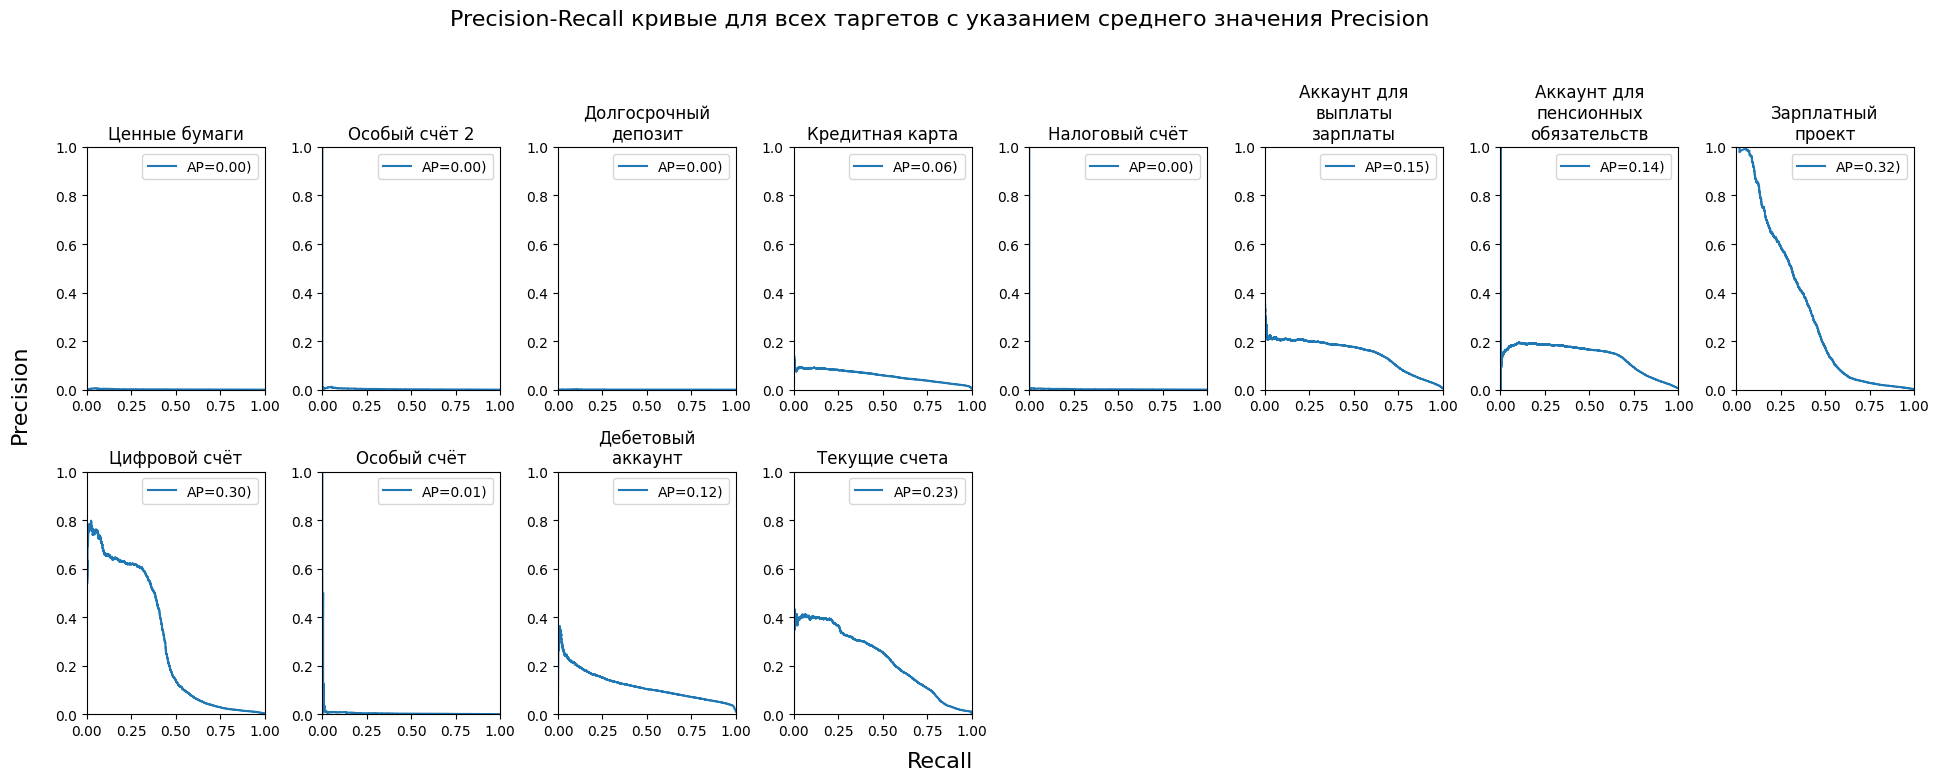

In [63]:
rows = number_of_targets // 8 + 1

fig, axs = plt.subplots(rows, 8, figsize=(20, rows*4))

# Flatten the axes array for easier iteration
axs = axs.flatten()

# Loop through the axes and assign a precision-recall curve plot to each subplot
for i, ax in enumerate(axs[:number_of_targets]):
    precision, recall, _ = precision_recall_curve(y_true.values[:, i], y_pred_proba[i][:, 1])

    avg_precision = average_precision_score(y_true.values[:,i], y_pred_proba[i][:,1])

    ax.plot(recall, precision, label=f'AP={avg_precision:.2f})')
    title = "\n".join(textwrap.wrap(target_names[i], width=15))  
    ax.set_title(title)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.legend()

for i in range(number_of_targets, rows * 8):
    axs[i].axis('off')

plt.suptitle("Precision-Recall кривые для всех таргетов с указанием среднего значения Precision", fontsize=16)
fig.text(0.5, 0.04, 'Recall', ha='center', va='center', fontsize=16)
fig.text(0.04, 0.5, 'Precision', ha='center', va='center', rotation='vertical', fontsize=16)

plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])

plt.show()

Как видим, более половины таргетов нерепрезентативны и не распознаются моделью.  Кривые более популярных таргетов имеют разную форму, и, как следствие, разные оптимальные пороги.  
Выведем общую картину метрик и мощности действительных значений и предсказаний для каждого таргета.

In [64]:
target_names = [v['rus'] for k, v in X_train.attrs.items() if k in [col[len('target__'):] for col in target_cols]]

In [65]:
f1_scores = [f1_score(y_true.values[:, i], y_pred[:, i]) for i in range(number_of_targets)]
precision_scores = [precision_score(y_true.values[:, i], y_pred[:, i]) for i in range(number_of_targets)]
recall_scores = [recall_score(y_true.values[:, i], y_pred[:, i]) for i in range(number_of_targets)]

# Create a DataFrame with F1, Precision, and Recall for each target
df = pd.DataFrame({
    'Target': target_names,
    'F1 Score': f1_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'Количество y_true': np.sum(y_true, axis=0),
    'Количество y_pred': np.sum(y_pred, axis=0),
})

# Set 'Target' as the index
df.set_index('Target', inplace=True)

df.style.background_gradient(cmap='Blues').format(precision=2)

,F1 Score,Precision,Recall,Количество y_true,Количество y_pred
Target,,,,,
Текущие счета,0.00,0.00,0.28,183,35501
Зарплатный проект,0.00,0.00,0.37,131,22951
Особый счёт,0.00,0.00,0.26,46,23504
Особый счёт 2,0.04,0.02,0.90,4248,168310
Долгосрочный депозит,0.00,0.00,0.62,279,142724
Цифровой счёт,0.10,0.05,0.85,5486,90199
Налоговый счёт,0.11,0.06,0.82,5511,77816
Кредитная карта,0.04,0.02,0.83,2343,104434
Ценные бумаги,0.03,0.02,0.86,2709,139669


Отсюда также видно, что не- или слабо-репрезентативные таргеты модель почти не обрабатывает, зато неплохо определяет популярные категории.  
Выведем еще важные детализированные значения для каждого таргета - зачения важностей признаков модели.  
(Для динамического вывода названий признаков придется 'вытаскивать' их из модели.)

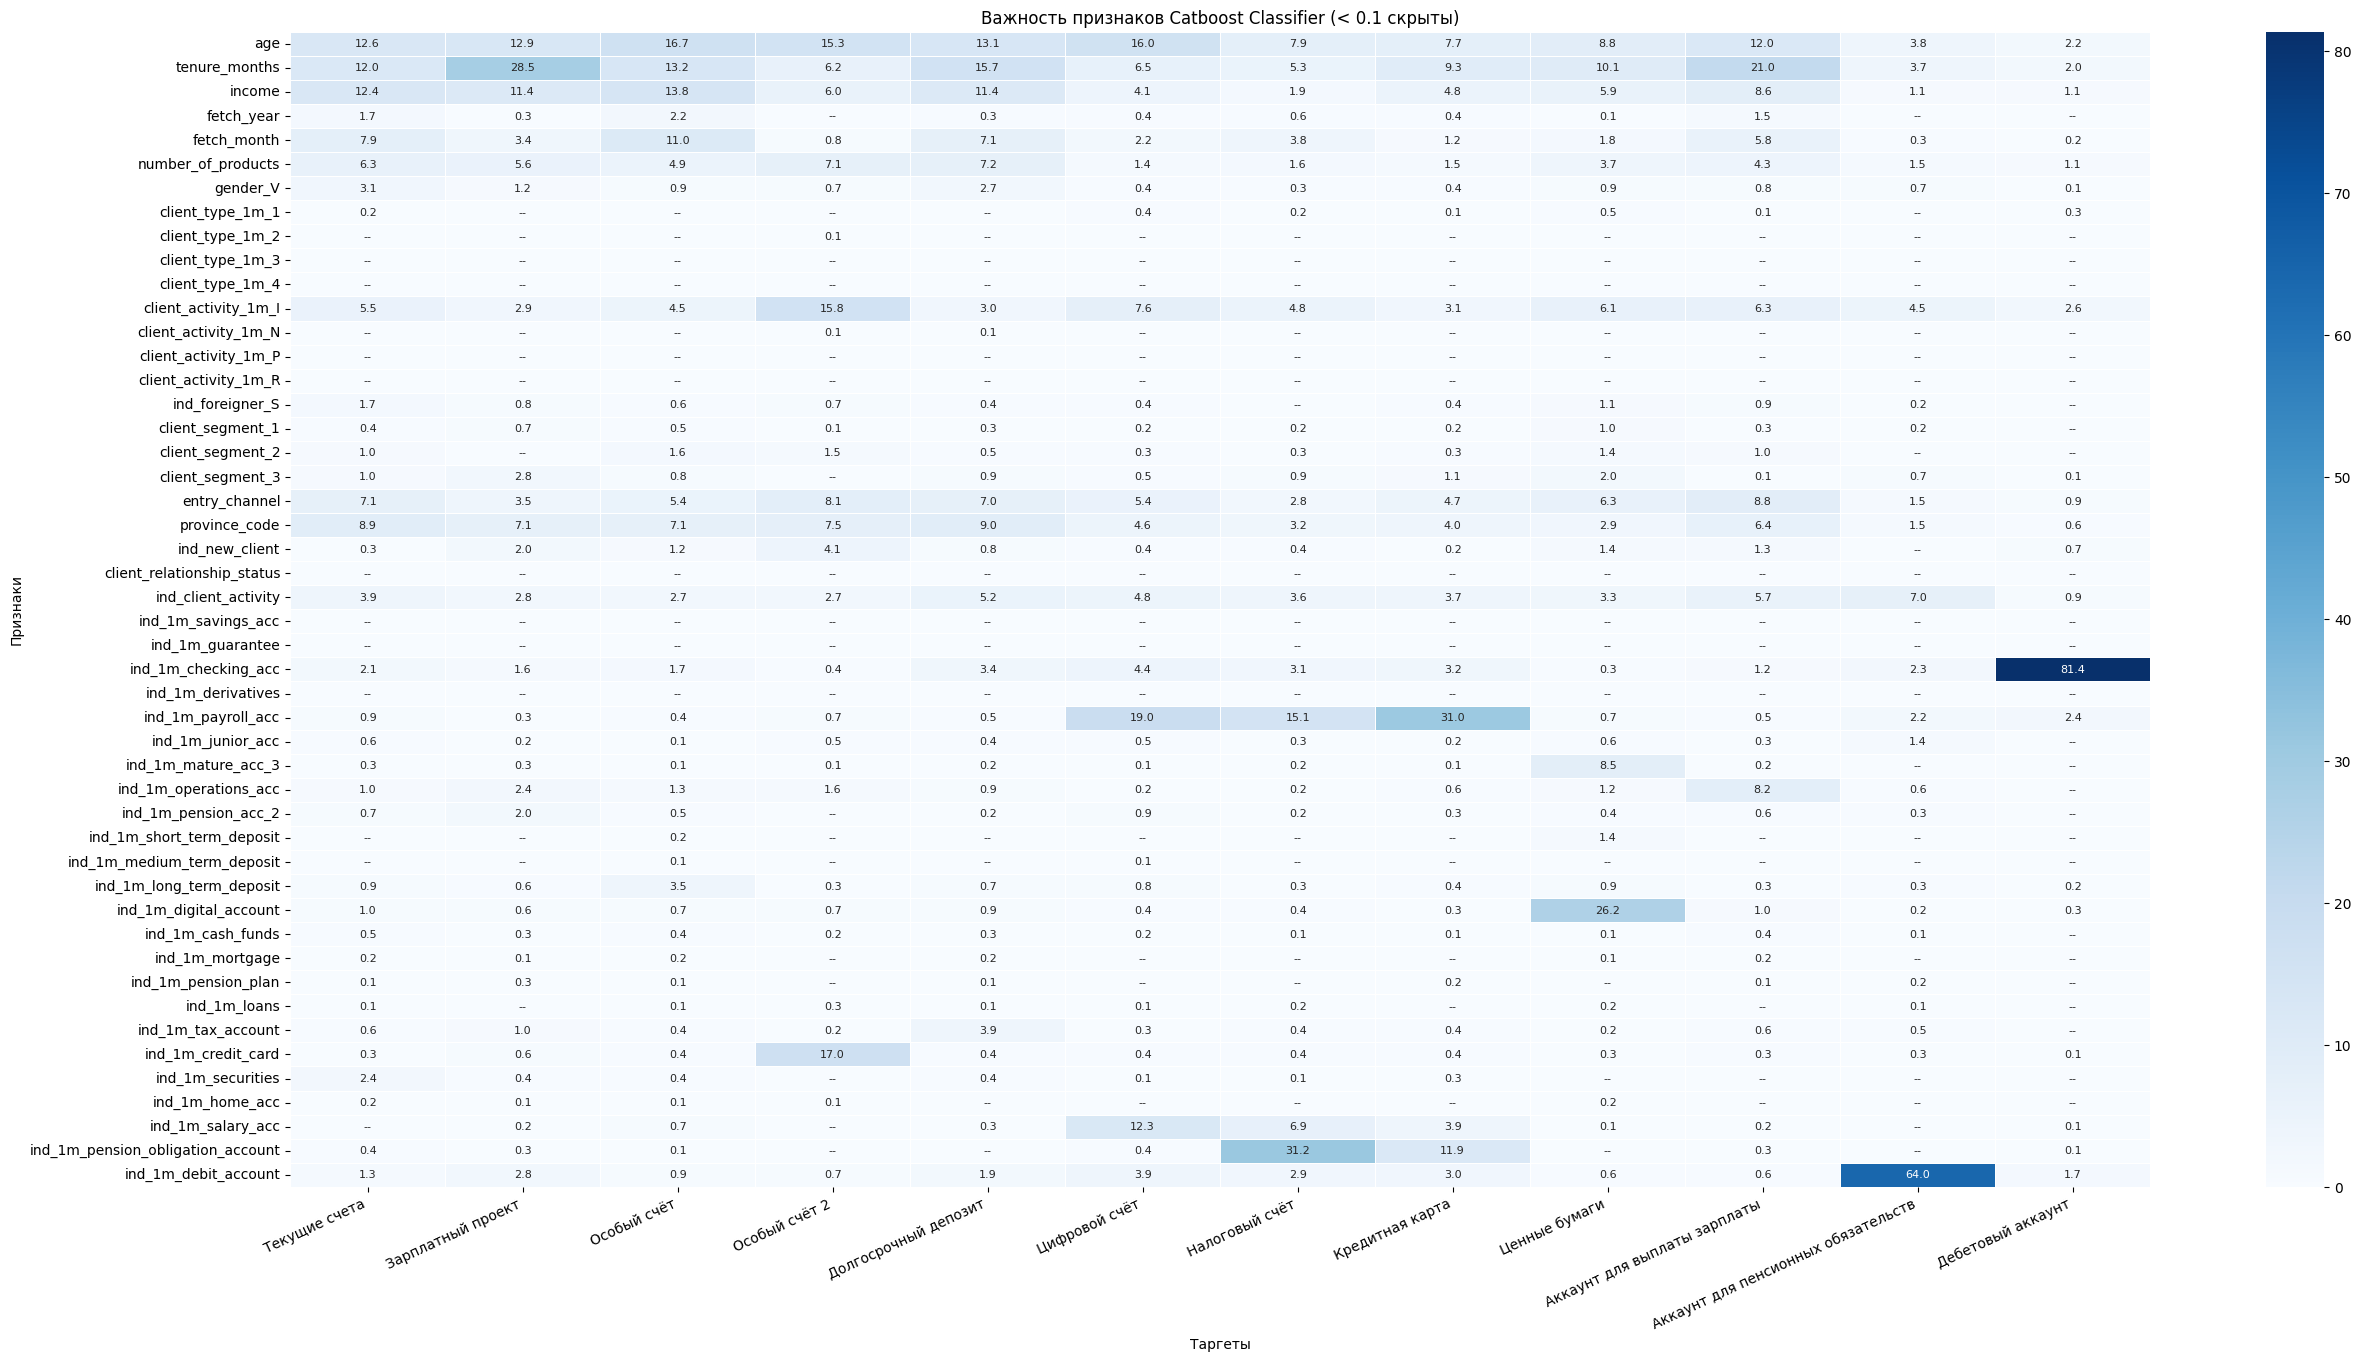

In [66]:
# Extract the encoder step from the model's pipeline
encoder = model.named_steps['encoder']

# Get the one-hot encoded feature names after applying the encoder transformation
onehot_features = encoder.transformers_[1][1].get_feature_names_out(one_hot_columns).tolist()

# Combine numerical features, one-hot encoded features, and frequency-encoded columns
encoder_features_out = numerical_features + onehot_features + freq_encode_columns

# Transform the first row of the training data (empty row) using the preprocessor step to get the preprocessed column names
preprocessed_data = model.named_steps['preprocessor'].transform(X_train[:0])
preprocessed_columns = pd.DataFrame(preprocessed_data).columns

# Filter out columns that represent targets, as they are not features
preprocessed_columns = [col for col in preprocessed_columns if not col.startswith('target_')]

# Identify passthrough columns that were not explicitly processed
passthrough_columns = [
    col for col in preprocessed_columns 
    if col not in numerical_columns 
    and col not in one_hot_columns 
    and col not in freq_encode_columns
]

# Combine all features (encoded and passthrough) into one list of feature names
feature_names = encoder_features_out + passthrough_columns

# Extract feature importances for each target from the model's estimators (multi-output CatBoost classifier)
estimators = model.steps[2][1].estimators_
feature_importances = [estimators[i].get_feature_importance() for i in range(len(estimators))]

# Create a DataFrame for feature importances with targets as rows and features as columns
df_importances = pd.DataFrame(feature_importances, index=target_names, columns=feature_names).T

plt.figure(figsize=(30, 15))

# Hiding values below 0.1
annot = df_importances.applymap(lambda v: f'{v:,.1f}' if v > 0.1 else '--')

sns.heatmap(df_importances, annot=annot, cmap='Blues', annot_kws={"size": 8}, fmt='', linewidths=0.5)

plt.title('Важность признаков Catboost Classifier (< 0.1 скрыты)')
plt.xticks(rotation=25, ha='right')
#plt.yticks(rotation=0)  # Rotate y-axis labels horizontally
plt.xlabel('Таргеты')
plt.ylabel('Признаки')
plt.show()

Модель определила нетривиальные зависимости (тот же 'gender', у которого коэффициенты phik ~ 0), большинство заметных значений важностей признаков - между текущим состоянием счетов и таргетами (если продукт не приобретен, то вероятность его купить больше), а также time-series признаки 'tenure_months', 'fetch_month'.  
  
В завершение получим еще одну важную метрику 'Точность попаданий в Toп-5', которая неплохо характеризует несбалансированные предсказания, а именно, какой процент предсказаний попадает в топ-5 популярных таргетов.

$$\text{Top-5 Accuracy} = \frac{1}{N} \sum_{i=1}^{N} \mathbb{1} \left( \text{True Label}_i \in \text{Top 5 Predictions}_i \right)$$
здесь N - количество наблюдений,  
1(⋅) - индикаторная функция, возвращающая 1, если y_true находится в топ-K предсказаний для i-го наблюдения, и 0 - в противном случае

In [67]:
# The number of top predictions to consider
K = 5

# Function to calculate Top-K Accuracy (Hits@K) when y_pred_proba is (number_of_targets, N, [0,1])
def top_k_accuracy(y_true, y_pred_proba, K):
    hits = 0
    num_instances = y_true.shape[0]

    for i in range(num_instances):
        pred_probs = y_pred_proba[:, i, 1]
        
        # Get the indices of the top K predicted probabilities for the positive class
        top_k_preds = np.argsort(pred_probs)[-K:]
        
        # Check if any of the true labels are in the top K predictions
        if np.any(y_true[i, top_k_preds] == 1):
            hits += 1
    
    # Return Top-K Accuracy as the proportion of hits
    return hits / num_instances

# Calculate Top-K Accuracy for K=5
top_k_acc = top_k_accuracy(y_true.values, np.array(y_pred_proba), K)
print(f"Top-{K} Accuracy (Hits@{K}): {top_k_acc:.4f}")

Top-5 Accuracy (Hits@5): 0.0288


##### Итоги этапа моделирования
 - поднят сервер MLFlow
 - загружен тренировочный датасет и сохраненная модель
 - подобран объем тренировочных данных (данные за 8 месяцев), тестовых данных (за 2 месяца) и параметры модели (малое количество итераций = 100, веса классов = [1, 4])
 - проведена подготовка к встраиванию модели в сервис предсказаний
 - получены метрики модели и проведена их интерпретация:
   - Precision	0.3167
   - Recall	0.2371
   - F1	0.2712
   - ROC AUC	0.9581
   - Top-5 Accuracy (Hits@5): 0.1332
 - проведено сравнение результатов предсказаний модели с константными предсказаниями
 - на протяжении всего этапа производилось логирование артефактов и метрик в текущем запуске эксперимента MLFlow
 - обученная модель залогирована, запуск эксперимента окончен
 - построенная структура позволяет проводить оптимизацию (кросс-валидацию) пайплайна обработки данных и подбора алгорима обучения и гиперпараметров с использованием инструментов sklearn или Optuna
 - получены метрики для каждого таргета в отдельности, что указывает направления улучшения чувствитльности модели к малорепрезентативным таргетам
 - в целом, создан рабочий ML-пайплайн с ETL-этапами, моделированием, логированием и анализом результатов.

<b>Комментарий от ревьюера v1</b>


    
# Общий вывод
<div class="alert alert-block alert-success">

Спасибо за работу, у тебя получился отличный проект, мне было приятно его проверять. 
Проведен отличный EDA, сделаны выводы!
    
Удалось реализовать алгоритм для формирования рекомендаций банковских продуктов. Для такой задачи действительно очень подходит multilabel постановка. Модели и метрики залогированы!
    
Есть небольшие замечания. Просьба ознакомиться с ними и учитывать в дальнейшей работе.
    
Если у тебя нет вопросов - отправляй проект обратно и я его приму!
</div>

<div class="alert alert-block alert-info">
<b>Комментарий студента v1: </b>   

Я попытался отработать все замечания. 
Считаю, что базовые вещи - то, что дается в спринте - можно сделать по учебным материалам, а замечания позволяют выяснить, что осталось недоработанным.  
Прошу объективно оценить, остались ли еще какие-либо замечания, недоработки.  
В этом проекте обратная связь была, мягко говоря, не лучшей, поэтому мне, как студенту, у которого не было практики программиста, замечания ревьюера оцень ценны.  
Может быть, ты дашь оценку по коду на предмет избыточности, слабых моментов и т.п.  
И под занавес вопрос: насколько наши проекты (и этот, в частности), близки к реальной работе?   
  
В любом случае, спасибо за ревью!
Удачи!

Владимир.
</div>